#  Install package

In [81]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai
# ! pip install contextily
# ! pip install matplotlib_scalebar

# Import package

In [82]:
import os
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

import base64

import pickle


# Define Solution class
Please run the following cell to define the functions

In [83]:
%load_ext autoreload
%autoreload 2

import LLM_Cat_Constants as constants
import helper

from LLM_Cat_kernel import Solution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demonstration Cases

## Input task and data desciption

In [84]:
# isReview = True
isReview = False

In [85]:
# Case 1
# task_name ='Census_map'
# TASK = r'''1. Create a thematic map to show the Census block group population. The location is Centre County, PA, USA. 
# 2. Carefuly design the map, make it beautiful and aesthetic appeal. The title, north arrow, scalebar, legend, and designer are needed. The designer is "LMM-Cat".
# 3. The map dimension is letter (8*11 inches) size.
# 4. Add a basemap.
# '''



# # Case 2:
# DATA_LOCATIONS = [
#     """Population file, GeoPackage format: E:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\centre_county_CBG.gpkg. Only one layer, no need to load it using a layer name. The population is in the 'totalpopulation' column. The map projection is Lambert Conformal Conic, EPSG 6564, StatePlane Pennsylvania South. The unit is meter.
#     """
# ]

# Case 2:

task_name = 'map_matrix'

TASK = r""" 1. Create a choropleth map to show the per capita GDP of African countries in the year 2022. The map should have two equal-sized parts on the same page. You need to show a large GDP choropleth African continent submap with all African countries on the left part, and another map matrix of 9 rows * 6 columns on the right part, each submap in the map matrix shows an individual country in Africa, ordered by the per capita GDP; the filling color of each country in the map matrix should as the same as its color in the continent map; you need to use the country name as the submap title. 
2. Carefully design the map and make it beautiful and aesthetically appealable. The title, north arrow, scalebar, legend, and designer are needed for the Africa map, but not for the map matrix. The designer is 'LMM-Cat'.
3. The map dimension is the landscape letter (11*8 inches) size, DPI is 150.
"""

DATA_LOCATIONS = [
"""
"Country per capita GPD file, GeoPackage format: E:\\OneDrive_PSU\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\ESRI_countries_4326_GDP.gpkg.  Only one layer, no need to load it using a layer name. The country name column is 'COUNTRY'. The map projection is EPSG 4326. The continent column is 'UN_Geodata_simplified_georeg'; 'AFR' indicates Africa in this column. The 2022 GDP column is 'country_per_capita_GDP_2022'
"""
]


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model=r"gpt-4"
# model = r'gpt-4-turbo-preview'
model = r'gpt-4-turbo'
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional cartographer and programmer good at Python. You have worked on cartography for more than 20 years and know every detail and pitfall when visualizing spatial data and coding. You know how to set up workflows for cartography tasks well. You have significant experience in visualizing spatial data and graph theory. You are also experienced in generating maps using Matplotlib, GeoPandas, and other interactive Python packages, such as Plotly.
 

Your task: Generate a graph (data structure) only, whose nodes are a series of consecutive steps to make a map, including visualizing the data add map elements such as title, legend, scalebar, label, and annotation.:  
  1. Create a choropleth map to show the per capita GDP of African countries in the year 2022. The map should have two equal-sized parts on the same page. You need to show a large GDP choropleth African continent submap with all African countries on the left part, and another map

## Get graph code from GPT API

In [86]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

G = nx.DiGraph()

# Data Nodes
G.add_node("gdp_gpkg_path", node_type="data", data_path="E:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\ESRI_countries_4326_GDP.gpkg", description="Path to GeoPackage containing GDP data for countries")
  
# Operation Nodes
G.add_node("load_gdp_data", node_type="operation", description="Load GDP data from GeoPackage")
G.add_edge("gdp_gpkg_path", "load_gdp_data")
G.add_node("gdp_gdf", node_type="data", description="GeoDataFrame containing GDP data")
G.add_edge("load_gdp_data", "gdp_gdf")

G.add_node("filter_african_countries", node_type="operation", description="Filter out African countries based on continent column")
G.add_edge("gdp_gdf", "filter_african_countries")
G.add_node("african_gdf", node_type="data", description="GeoDataFrame containing only African countries")
G.add_edge("filter_african_countries", "african_gdf")

G.add_node("sort_by_gdp", node_type="operation", description="Sort African countries by GDP per capita")
G.add_edge("african_gdf", "sort_by_gdp")
G.add_node("sorted_african_gdf", node_type="data", description="Sorted GeoDataFrame by GDP")
G.add_edge("sort_by_gdp", "sorted_african_gdf")

G.add_node("create_choropleth_main", node_type="operation", description="Create main choropleth map for African continent")
G.add_edge("sorted_african_gdf", "create_choropleth_main")
G.add_node("main_map", node_type="data", description="Main choropleth map of Africa")
G.add_edge("create_choropleth_main", "main_map")

G.add_node("create_submaps", node_type="operation", description="Create a matrix of submaps for each African country")
G.add_edge("sorted_african_gdf", "create_submaps")
G.add_node("submaps", node_type="data", description="Matrix of submaps for individual countries")
G.add_edge("create_submaps", "submaps")

G.add_node("add_map_elements", node_type="operation", description="Add map elements to the main choropleth map")
G.add_edge("main_map", "add_map_elements")
G.add_node("map_with_elements", node_type="data", description="Main map with title, legend, scalebar")
G.add_edge("add_map_elements", "map_with_elements")

G.add_node("combine_maps", node_type="operation", description="Combine main map and submap matrix into a single layout")
G.add_edge("map_with_elements", "combine_maps")
G.add_edge("submaps", "combine_maps")
G.add_node("final_map_output", node_type="data", description="Final map output containing all mapped data")
G.add_edge("combine_maps", "final_map_output")

# Save the graph to a GraphML file
nx.write_graphml(G, "e:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\map_matrix\\map_matrix.graphml")

## Execute code to generate the solution graph

In [87]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

e:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\map_matrix.html


## Generate prompts and code for operations (functions)

In [88]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_gdp_data(gdp_gpkg_path='E:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\ESRI_countries_4326_GDP.gpkg'):
    """
    Load GDP data from a GeoPackage file containing GDP data for all countries.
    The GeoDataFrame will store GDP data for further processing, particularly focusing on African countries' GDP.
    """
    # Load the entire GeoPackage data using GeoPandas
    gdp_gdf = gpd.read_file(gdp_gpkg_path)
    
    # Ensure to load essential columns only and correct datatypes
    gdp_gdf = gdp_gdf[['COUNTRY', 'UN_Geodata_simplified_georeg', 'country_per_capita_GDP_2022', 'geometry']].copy()
    gdp_gdf['country_per_capita_GDP_2022'] = pd.to_numeric(gdp_gdf['country_per_capita_GDP_2022'], errors='coerce')

    return gdp_gdf
import geopandas as gpd

def filter_african_countries(gdp_gdf):
    """
    Filter out African countries based on continent column
    """
    # Filter to include only rows where the continent column indicates Africa ('AFR')
    african_gdf = gdp_gdf[gdp_gdf['UN_Geodata_simplified_georeg'] == 'AFR'].copy()
    
    return african_gdf
import geopandas as gpd

def sort_by_gdp(african_gdf):
    """
    Sort African countries by GDP per capita.
    """
    # Sorting the GeoDataFrame by the GDP per capita column in descending order to prioritize countries with higher GDP
    sorted_african_gdf = african_gdf.sort_values(by='country_per_capita_GDP_2022', ascending=False)
    
    return sorted_african_gdf
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors

def create_choropleth_main(sorted_african_gdf):
    """
    Create main choropleth map for African continent
    """
    # Set up the figure size for landscape letter size with arbitrary division to allocate space for both main and submap matrix
    fig, ax = plt.subplots(1, 1, figsize=(11, 8), dpi=150)

    # Create the choropleth map using the 'country_per_capita_GDP_2022' column
    main_map = sorted_african_gdf.plot(column='country_per_capita_GDP_2022', ax=ax, legend=True,
                                       cmap='OrRd', edgecolor='black', linewidth=0.8, 
                                       legend_kwds={'label': "GDP per capita (USD)",
                                                    'orientation': "horizontal"})

    # Aesthetics adjustments and elements
    ax.set_title('GDP per Capita of African Countries in 2022', fontdict={'fontsize': 15}, pad=12)
    ax.set_axis_off()  # Hide axis
    
    # Adding a scale bar
    from matplotlib_scalebar.scalebar import ScaleBar
    ax.add_artist(ScaleBar(1, location='lower left', scale_loc='bottom', units='km', length_fraction=0.1))

    # Add the designer's name as requested
    ax.annotate('Map design by LMM-Cat', xy=(0.1, 0.1), xycoords='figure fraction', fontsize=8, color='gray')

    return main_map
import matplotlib.pyplot as plt
import geopandas as gpd

def create_submaps(sorted_african_gdf):
    """
    Create a matrix of submaps for each African country
    """
    # Setting the dimensions for the subplot matrix
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(11, 8), dpi=150)
    
    # Flatten axes for easy iteration
    ax_list = axes.flatten()
    
    # Hide unused axes if there are fewer than 54 African countries
    for i in range(len(sorted_african_gdf), 54):
        ax_list[i].set_visible(False)
    
    # Loop through each country and create a submap
    for (idx, row), ax in zip(sorted_african_gdf.iterrows(), ax_list):
        # Create a temporary GeoDataFrame for individual country
        temp_gdf = gpd.GeoDataFrame([row], crs=sorted_african_gdf.crs)
        
        # Plotting the country on an individual axis
        temp_gdf.plot(ax=ax, color='c', edgecolor='black')
        
        # Setting the title to the country name
        ax.set_title(row['COUNTRY'], fontsize=8)
        
        # Remove axis lines
        ax.set_xticks([])
        ax.set_yticks([])
      

## Generate prompts and code for assembly program

In [89]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd

def load_gdp_data(gdp_gpkg_path='E:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\ESRI_countries_4326_GDP.gpkg'):
    gdp_gdf = gpd.read_file(gdp_gpkg_path)
    gdp_gdf = gdp_gdf[['COUNTRY', 'UN_Geodata_simplified_georeg', 'country_per_capita_GDP_2022', 'geometry']].copy()
    gdp_gdf['country_per_capita_GDP_2022'] = pd.to_numeric(gdp_gdf['country_per_capita_GDP_2022'], errors='coerce')
    return gdp_gdf

def filter_african_countries(gdp_gdf):
    african_gdf = gdp_gdf[gdp_gdf['UN_Geodata_simplified_georeg'] == 'AFR'].copy()
    return african_gdf

def sort_by_gdp(african_gdf):
    sorted_african_gdf = african_gdf.sort_values(by='country_per_capita_GDP_2022', ascending=False)
    return sorted_african_gdf

def create_choropleth_main(sorted_african_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 8), dpi=150)
    main_map = sorted_african_gdf.plot(column='country_per_capita_GDP_2022', ax=ax, legend=True,
                                       cmap='OrRd', edgecolor='black', linewidth=0.8, 
                                       legend_kwds={'label': "GDP per capita (USD)",
                                                    'orientation': "horizontal"})
    ax.set_title('GDP per Capita of African Countries in 2022', fontdict={'fontsize': 15}, pad=12)
    ax.set_axis_off()
    ax.add_artist(ScaleBar(1, location='lower left', scale_loc='bottom', units='km', length_fraction=0.1))
    ax.annotate('Map design by LMM-Cat', xy=(0.1, 0.1), xycoords='figure fraction', fontsize=8, color='gray')
    plt.tight_layout()
    return ax

def create_submaps(sorted_african_gdf):
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(5.5, 8), dpi=150, sharex=True, sharey=True)
    ax_list = axes.flatten()
    for i in range(len(sorted_african_gdf), 54):
        ax_list[i].set_visible(False)
    for (idx, row), ax in zip(sorted_african_gdf.iterrows(), ax_list):
        temp_gdf = gpd.GeoDataFrame([row], crs=sorted_african_gdf.crs)
        temp_gdf.plot(ax=ax, color='c', edgecolor='black')
        ax.set_title(row['COUNTRY'], fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.tight_layout(pad=1.0)
    return fig

def combine_maps(submaps, map_with_elements):
    fig = plt.figure(figsize=(11, 8), dpi=150)
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
    submap_ax = fig.add_subplot(gs[0, 1])
    plt.sca(submap_ax)
    plt.axis('off')
    submaps.canvas.draw()
    plt.imshow(submaps.canvas.buffer_rgba())
    
    mainmap_ax = fig.add_subplot(gs[0, 0])
    plt.sca(mainmap_ax)
    mainmap_ax.get_xaxis().set_visible(False)
    mainmap_ax.get_yaxis().set_visible(False)
    map_with_elements.canvas.draw()
    plt.imshow(map_with_elements.canvas.buffer_rgba())
    plt.tight_layout()
    plt.savefig("output_map.png", dpi=100)
    return fig

def assembly_solution():
    gdp_gdf = load_gdp_data()
    african_gdf = filter_african_countries(gdp_gdf)
    sorted_african_gdf = sort_by_gdp(african_gdf)
    main_map = create_choropleth_main(sorted_african_gdf)
    submaps = create_submaps(sorted_african_gdf)
    result_map = combine_maps(submaps, main_map)
    return result_map

assembly_solution()

## Execute assembly code

In [90]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))
solution.all_code = all_code



-------------- Running code (trial # 1/10) --------------


Error_info_str: 
Traceback (most recent call last):
  File "Complete program", line 251, in <module>
    assembly_solution()
  File "Complete program", line 248, in assembly_solution
    result_map = combine_maps(submaps, main_map)
  File "Complete program", line 236, in combine_maps
    map_with_elements.canvas.draw()
AttributeError: 'AxesSubplot' object has no attribute 'canvas'

Sending error information to LLM for debugging...
Based on the error message and the review of the provided code, it appears that the error originates from attempting to draw on an `AxesSubplot` object incorrectly. Here's the breakdown of required fixes and rationales:

1. **Canvas Drawing Error**: The error `AttributeError: 'AxesSubplot' object has no attribute 'canvas'` indicates misuse of matplotlib objects. In Matplotlib, the `canvas` attribute belongs to `Figure` objects, not `AxesSubplot`. The program tries to invoke `canvas.draw()` on an ax

# Corrected Python Program Below
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar

def load_gdp_data(gdp_gpkg_path='E:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\ESRI_countries_4326_GDP.gpkg'):
    gdp_gdf = gpd.read_file(gdp_gpkg_path)
    gdp_gdf = gdp_gdf[['COUNTRY', 'UN_Geodata_simplified_georeg', 'country_per_capita_GDP_2022', 'geometry']].copy()
    gdp_gdf['country_per_capita_GDP_2022'] = pd.to_numeric(gdp_gdf['country_per_capita_GDP_2022'], errors='coerce')
    return gdp_gdf

def filter_african_countries(gdp_gdf):
    african_gdf = gdp_gdf[gdp_gdf['UN_Geodata_simplified_georeg'] == 'AFR'].copy()
    return african_gdf

def sort_by_gdp(african_gdf):
    sorted_african_gdf = african_gdf.sort_values(by='country_per_capita_GDP_2022', ascending=False)
    return sorted_african_gdf

def create_choropleth_main(sorted_african_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(5.5, 8), dpi=150)
    main_map = sorted_african_gdf.plot(column='country_per_capita_GDP_2022', ax=ax, legend=True,
                                       cmap='OrRd', edgecolor='black', linewidth=0.8, 
                                       legend_kwds={'label': "GDP per capita (USD)",
                                                    'orientation': "horizontal"})
    ax.set_title('GDP per Capita of African Countries in 2022', fontdict={'fontsize': 15}, pad=12)
    ax.set_axis_off()
    ax.add_artist(ScaleBar(1, location='lower left', scale_loc='bottom', units='km', length_fraction=0.1))
    ax.annotate('Map design by LMM-Cat', xy=(0.1, 0.1), xycoords='figure fraction', fontsize=8, color='gray')
    plt.tight_layout()
    return fig

def create_submaps(sorted_african_gdf):
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(5.5, 8), dpi=150, sharex=True, sharey=True)
    ax_list = axes.flatten()
    for i in range(len(sorted_african_gdf), 54):
        ax_list[i].set_visible(False)
    for (idx, row), ax in zip(sorted_african_gdf.iterrows(), ax_list):
        temp_gdf = gpd.GeoDataFrame([row], crs=sorted_african_gdf.crs)
        temp_gdf.plot(ax=ax, color='c', edgecolor='black')
        ax.set_title(row['COUNTRY'], fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    plt.tight_layout(pad=1.0)
    return fig

def combine_maps(submaps, main_map):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 8), dpi=150)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    # Set current axis to ax1 then draw the main map
    plt.sca(ax1)
    plt.imshow(main_map.canvas.buffer_rgba())
    
    # Set current axis to ax2 then draw submaps
    plt.sca(ax2)
    plt.imshow(submaps.canvas.buffer_rgba())
    plt.tight_layout()
    
    plt.savefig("output_map.png", dpi=100)
    return fig

def assembly_solution():
    gdp_gdf = load_gdp_data()
    african_gdf = filter_african_countries(gdp_gdf)
    sorted_african_gdf = sort_by_gdp(african_gdf)
    main_map = create_choropleth_main(sorted_african_gdf)
    submaps = create_submaps(sorted_african_gdf)
    result_map = combine_maps(submaps, main_map)
    return result_map

assembly_solution()

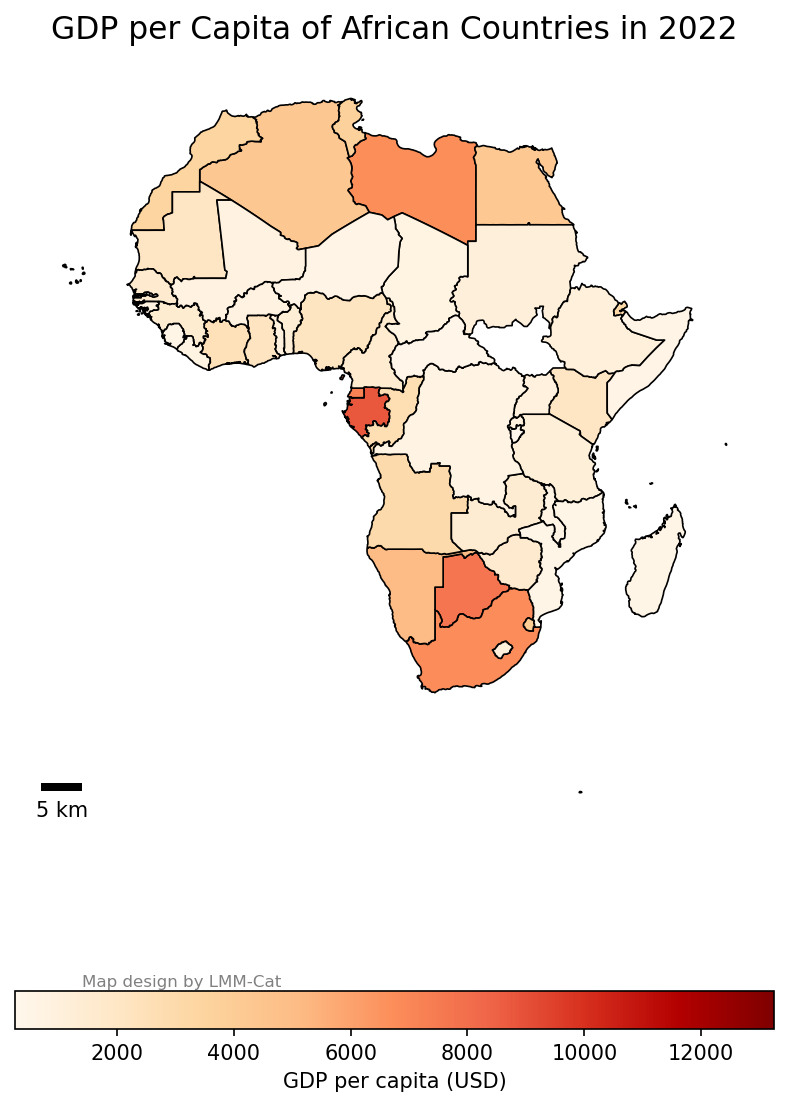

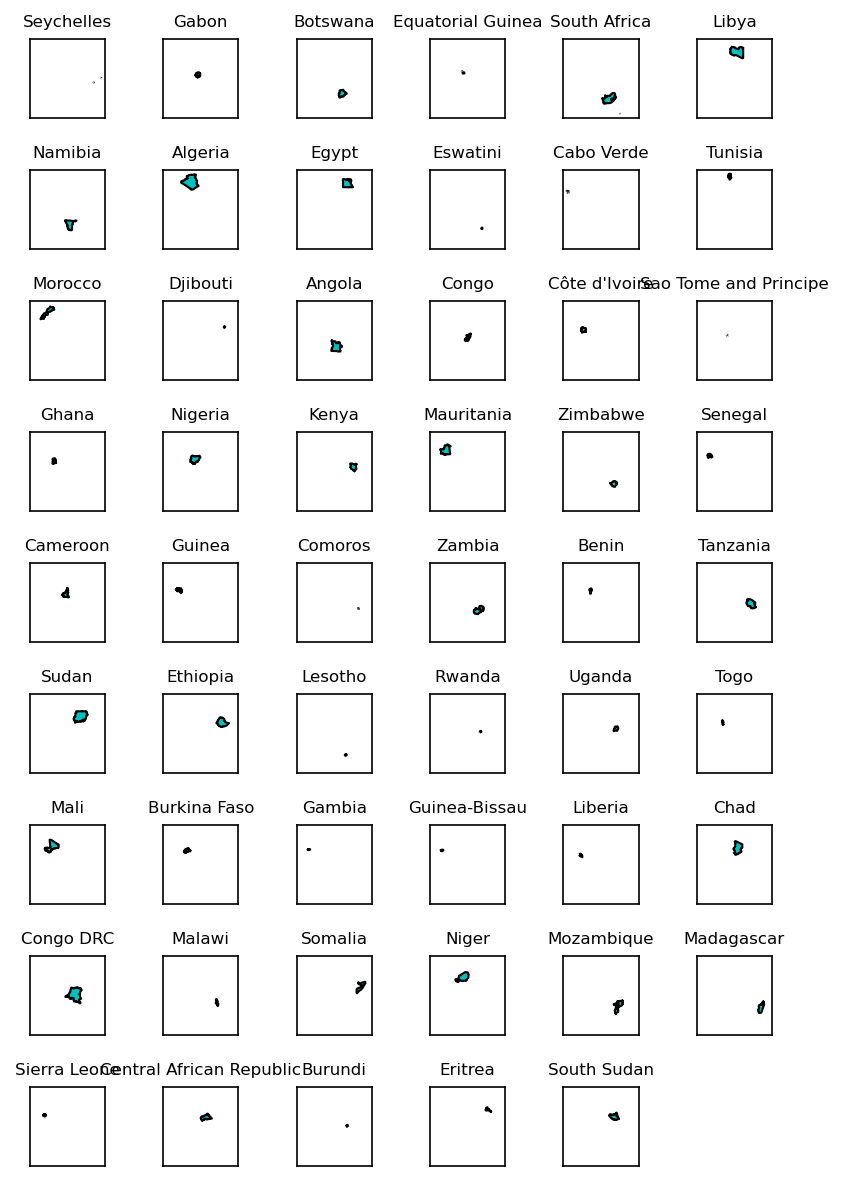

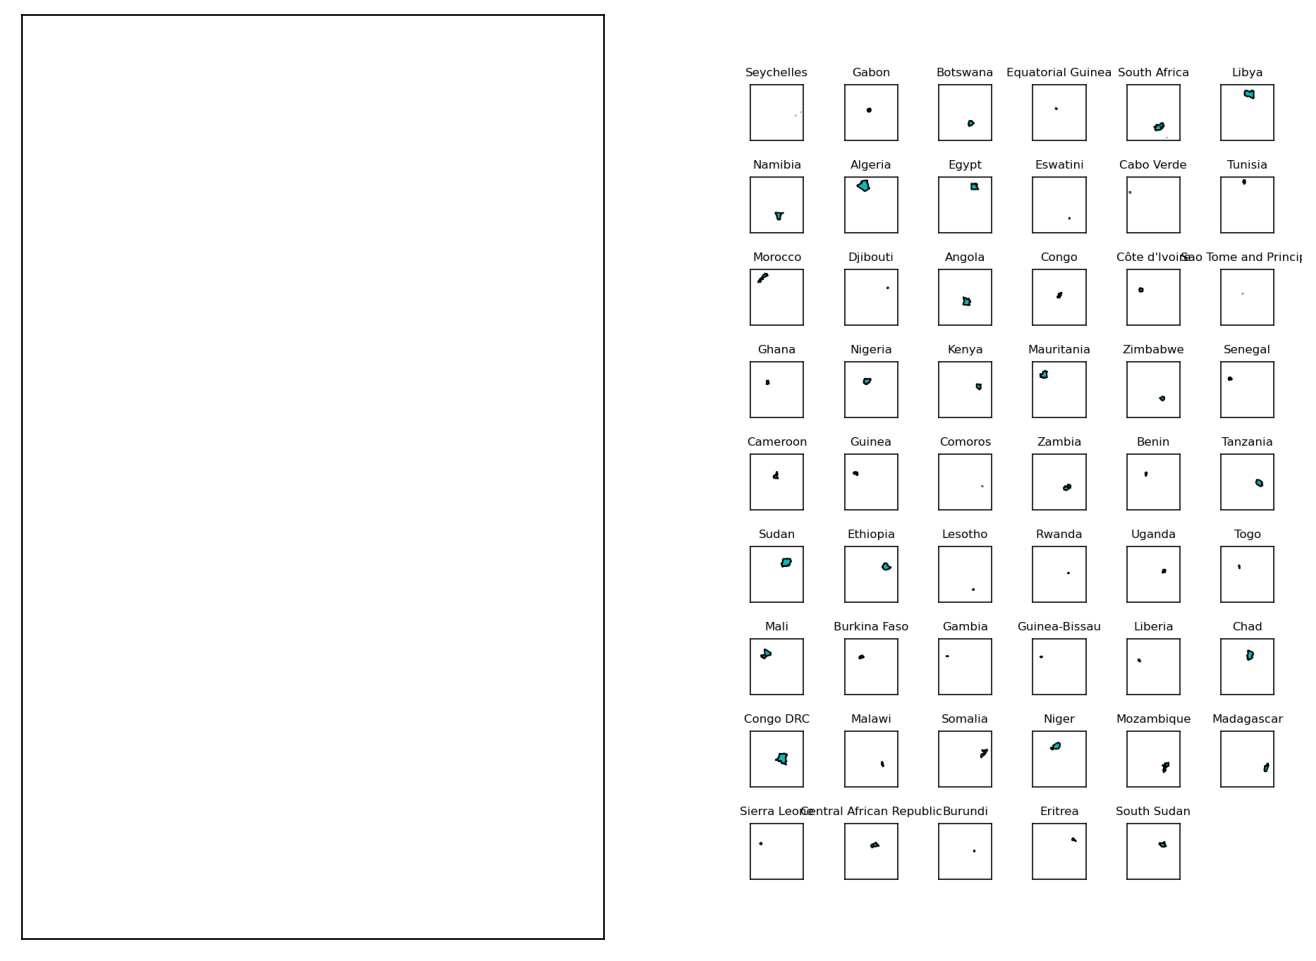

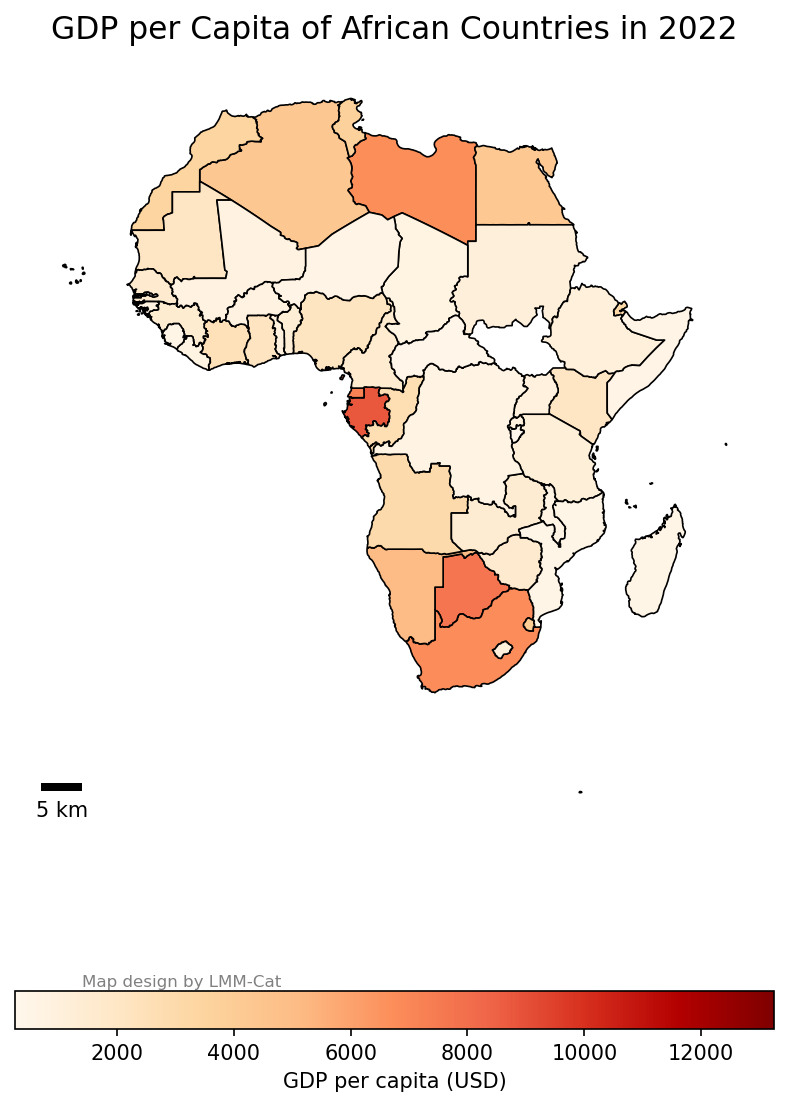

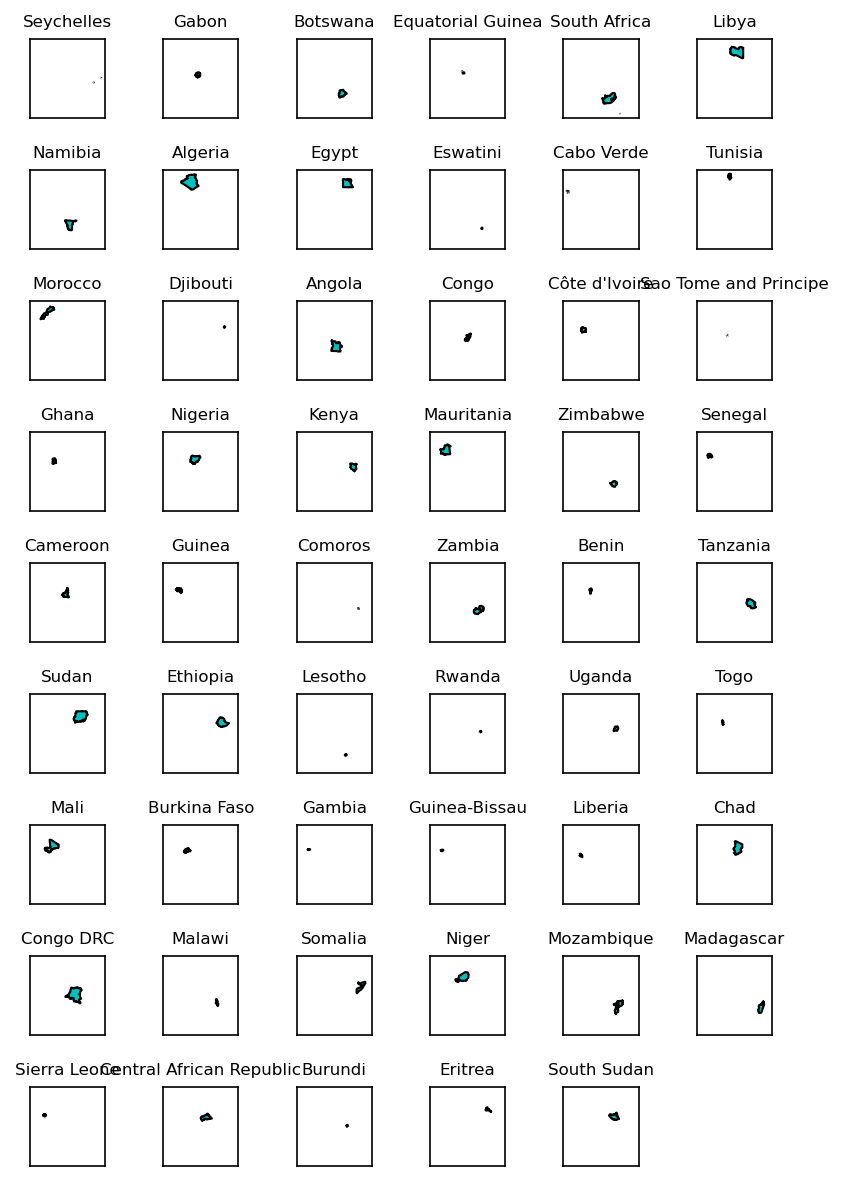

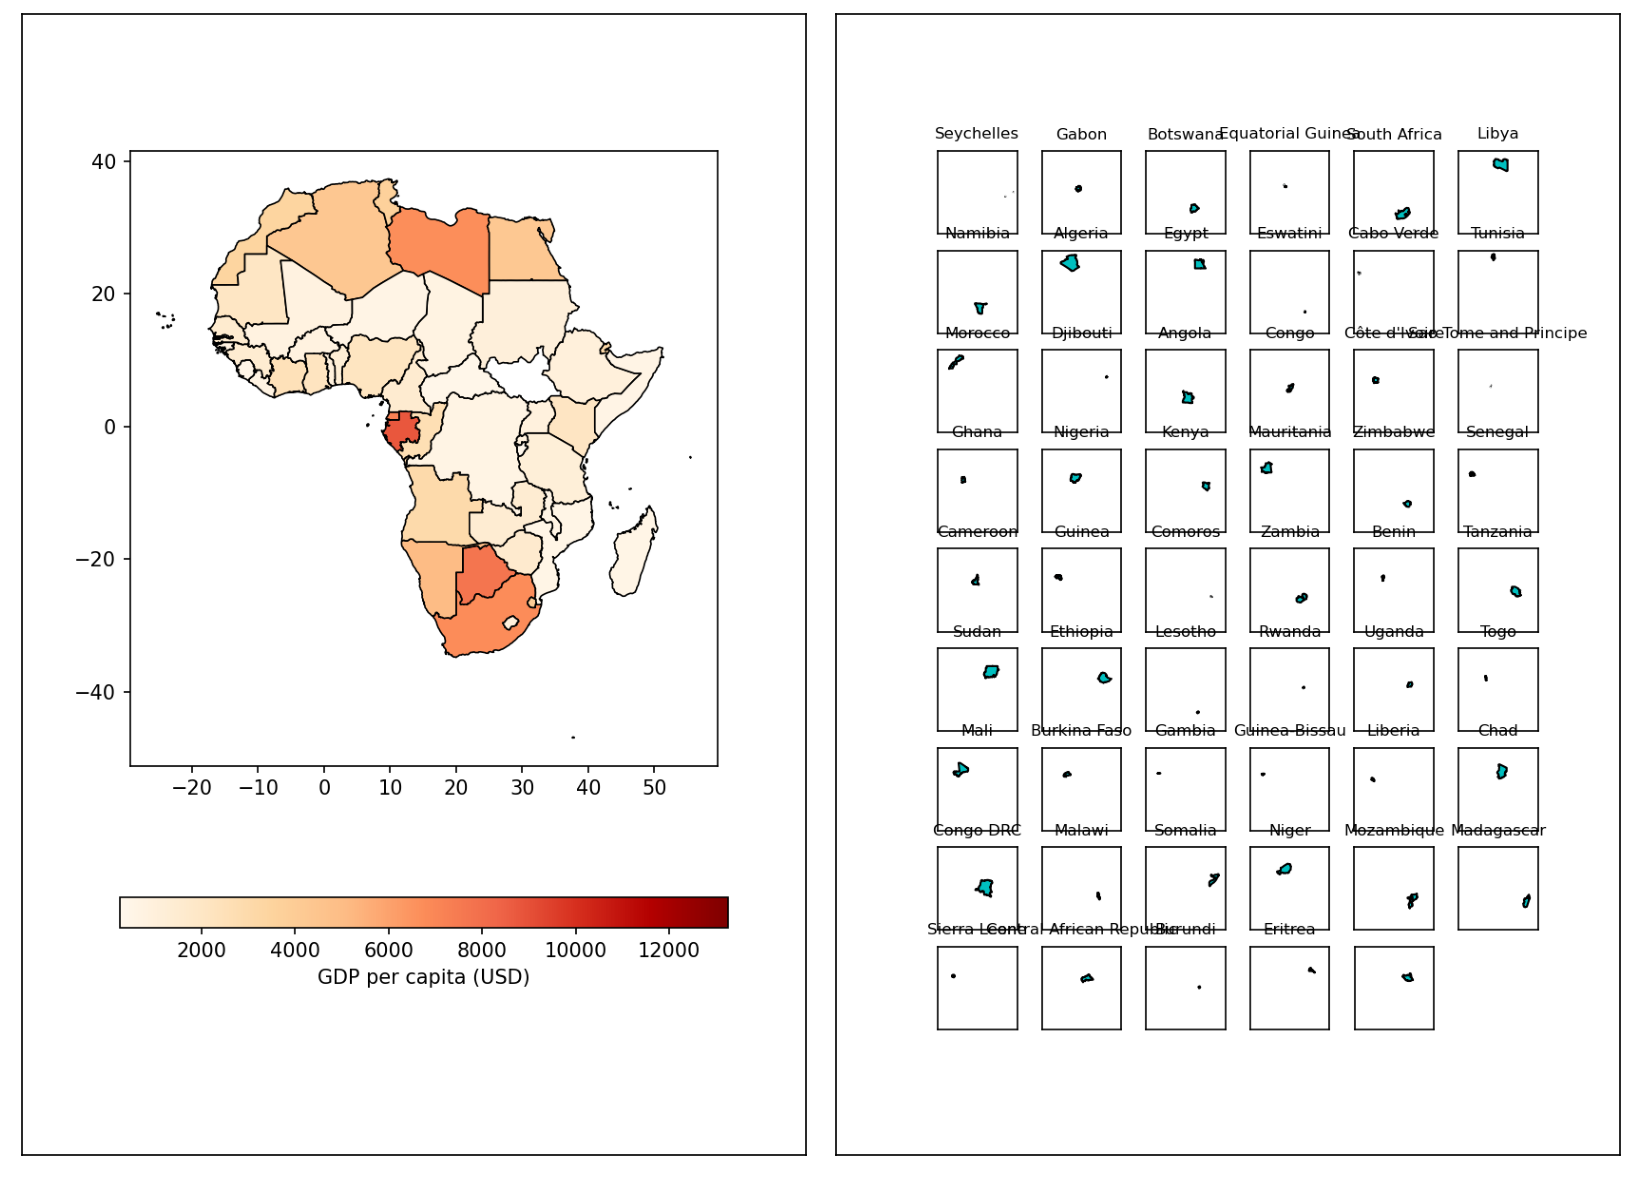

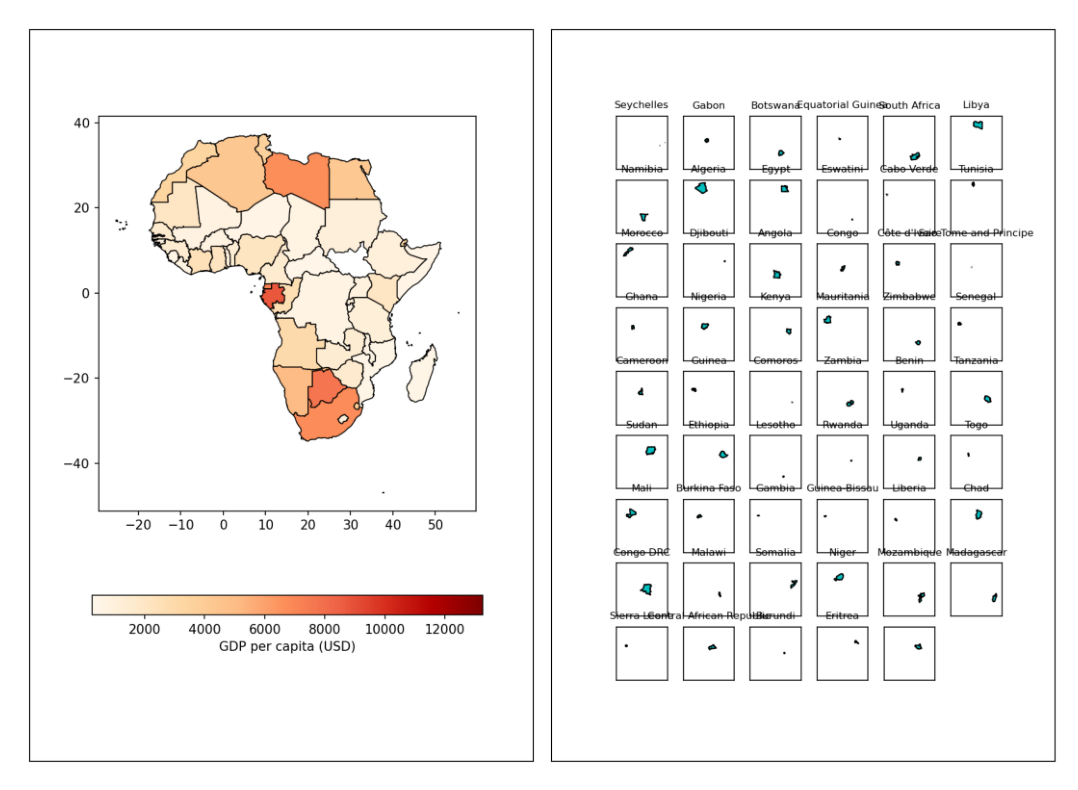

In [91]:
all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

solution.all_code = all_code

image_path = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\output_map.png"
from PIL import Image
import matplotlib.pyplot as plt

def show_map():
    image = Image.open(image_path)    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_axis_off()
    plt.imshow(image)
    
show_map()   
display(Code(all_code, language='python'))

In [92]:
# display(Code(all_code, language='python'))

# Beautify map

In [93]:
print(solution.get_review_prompt())

Your role: A professional cartographer. You have worked on cartography for more than 20 years and know how to design an aesthetic appeal map. Your current job is to review the map generated by AI. You need to detail the issues with the given map so that the AI can improve the map later. Note that AI makes the map via generated code, so your comments should be suitable for improvements by code. The map requirements are also provided.
 
Your task: Observe the given map carefully using the viewpoint of an experienced cartographer. 

Requirements: 
1. Elaborate on the issues, then provide specific and actionable improvements, such as 'move the legend to the up-left to void obscuring'. If you think there is no issue, no need to mention it.
2. Whether the map meets cartography requirements for the map.
3. Whether the title semantically meets the data and map requirement.
4. Whether the fonts and font sizes are suitable and hierachical.
5. Wheter the map is in the center.
6. Whether the legen

## Map review

1. The title of the map is missing: add a title to the map to clearly indicate what the map represents.
2. The legend and the color bar do not use the same colormap: synchronize the colormap used in both the large map and the map matrix for consistency.
3. The font sizes are inconsistent and small across the map elements: increase and harmonize the font sizes for better legibility.
4. The map is not centered on the page: adjust the map positioning to be centered within the layout.
5. The sizes of the map elements (title, north arrow, legend, scale bar) are too small: increase the size of these elements to improve visibility and effectiveness.
6. The north arrow and scale bar are missing on the African continent map: add these elements to enhance the map’s utility.
7. The legend overlaps with the scale bar, making it difficult to read: relocate the scale bar or adjust its size to avoid overlap.
8. The DPI does not meet the specified requirement of 150: adjust the DPI to 150 to match the

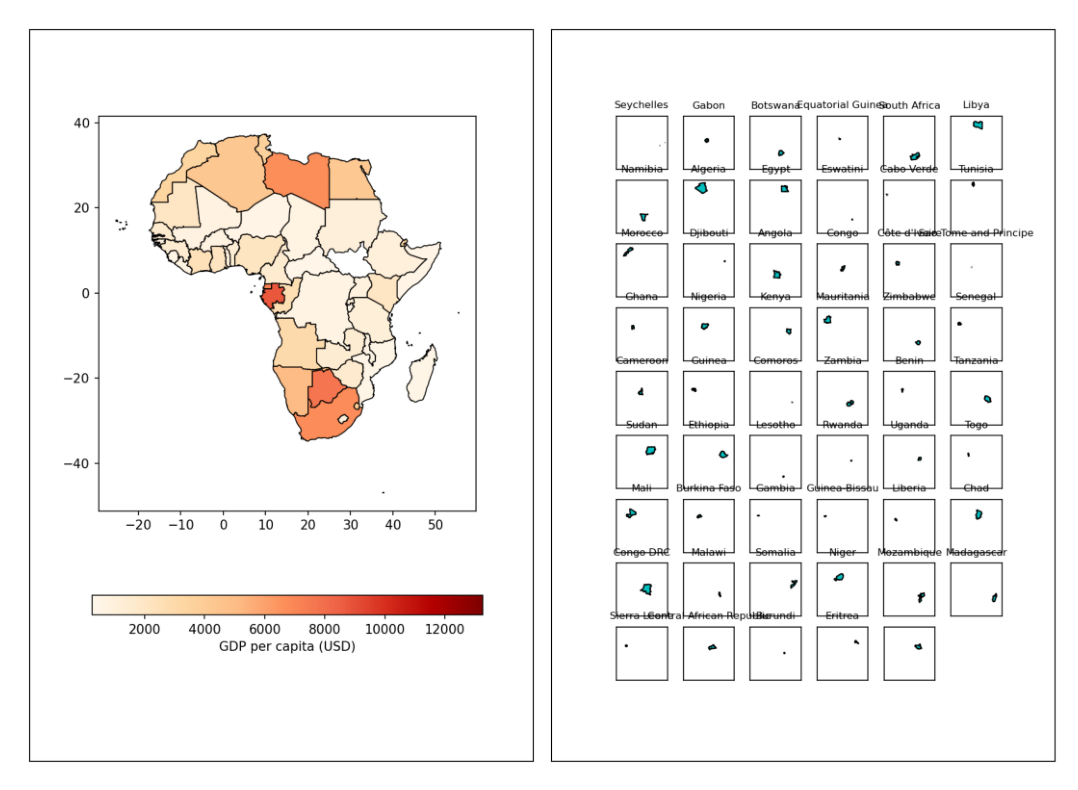

In [94]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = r"E:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\output_map.png"

# Getting the base64 string
base64_image = encode_image(image_path)

from PIL import Image
import matplotlib.pyplot as plt

def show_map():
    image = Image.open(image_path)    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_axis_off()
    plt.imshow(image)


solution.ask_LLM_to_review_map(map_base64=base64_image, model='gpt-4-turbo')

show_map()

## Beautify 1

Revising the map, trial 1 / 1
Current map issues:
1. The main choropleth map seems too compressed which might affect the readability of smaller countries.
2. Font sizes of the country names in the submap matrix are too small, making them hard to read.
3. There's an inconsistency in the edge color of the submaps; some borders are visible while others are not.
4. The color mapping across the main map and the submaps appears inconsistent – it is crucial that colors directly correspond to ensure legibility and comprehension.
5. The legend on the main map is overlapping slightly with the map, which might block some details.
6. The overall alignment and spacing could be improved to make better use of available space and enhance the visual appeal.
7. The scale bar and the north arrow are missing, which are essential elements for geographical orientation and scale comprehension.

Improvement:
1. Adjust the layout and size of the main map to improve visibility of smaller countries.
2. Increase 

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar

def load_gdp_data(gdp_gpkg_path='E:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM-Cat\\ESRI_countries_4326_GDP.gpkg'):
    gdp_gdf = gpd.read_file(gdp_gpkg_path)
    gdp_gdf = gdp_gdf[['COUNTRY', 'UN_Geodata_simplified_georeg', 'country_per_capita_GDP_2022', 'geometry']].copy()
    gdp_gdf['country_per_capita_GDP_2022'] = pd.to_numeric(gdp_gdf['country_per_capita_GDP_2022'], errors='coerce')
    return gdp_gdf

def filter_african_countries(gdp_gdf):
    african_gdf = gdp_gdf[gdp_gdf['UN_Geodata_simplified_georeg'] == 'AFR'].copy()
    return african_gdf

def sort_by_gdp(african_gdf):
    sorted_african_gdf = african_gdf.sort_values(by='country_per_capita_GDP_2022', ascending=False)
    return sorted_african_gdf

def create_choropleth_main(sorted_african_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(11, 8), dpi=150)  # Adjusted for better layout
    main_map = sorted_african_gdf.plot(column='country_per_capita_GDP_2022', ax=ax, legend=True,
                                       cmap='OrRd', edgecolor='black', linewidth=0.8,
                                       legend_kwds={'label': "GDP per capita (USD)", 'orientation': "horizontal"})
    ax.set_title('GDP per Capita of African Countries in 2022', fontdict={'fontsize': 18}, pad=12)  # Increased font size
    ax.set_axis_off()
    scalebar = ScaleBar(100, location='lower left', scale_loc='bottom', units='km', length_fraction=0.25)  # Added longer scale bar
    ax.add_artist(scalebar)
    north = ax.annotate('North', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=10, ha='center')
    ax.annotate('Map design by LMM-Cat', xy=(0.1, 0.1), xycoords='figure fraction', fontsize=10, color='gray')
    plt.tight_layout()
    return fig

def create_submaps(sorted_african_gdf):
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(5.5, 8), dpi=150, sharex=True, sharey=True)
    ax_list = axes.flatten()
    for i in range(len(sorted_african_gdf)):
        ax = ax_list[i]
        temp_gdf = gpd.GeoDataFrame([sorted_african_gdf.iloc[i]], crs=sorted_african_gdf.crs)
        temp_gdf.plot(ax=ax, color='c', edgecolor='black')  # Standardized edge color
        ax.set_title(sorted_african_gdf.iloc[i]['COUNTRY'], fontsize=10)  # Increased font size
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
    for i in range(len(sorted_african_gdf), 54):
        ax_list[i].set_visible(False)
    plt.tight_layout(pad=1.0)
    return fig

def combine_maps(submaps, main_map):
    fig = plt.figure(figsize=(11, 8), dpi=150)  # Single figure for seamless integration
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 2])  # Adjusted grid spec ratios for better balance
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    ax1.axis('off')
    ax2.axis('off')

    # Set current axis to ax1 then draw the main map
    ax1.imshow(main_map.canvas.buffer_rgba())
    
    # Set current axis to ax2 then draw submaps
    ax2.imshow(submaps.canvas.buffer_rgba())
    
    plt.tight_layout()
    plt.savefig("output_map.png", dpi=100)
    return fig

def assembly_solution():
    gdp_gdf = load_gdp_data()
    african_gdf = filter_african_countries(gdp_gdf)
    sorted_african_gdf = sort_by_gdp(african_gdf)
    main_map = create_choropleth_main(sorted_african_gdf)
    submaps = create_submaps(sorted_african_gdf)
    result_map = combine_maps(submaps, main_map)
    return result_map

assembly_solution()

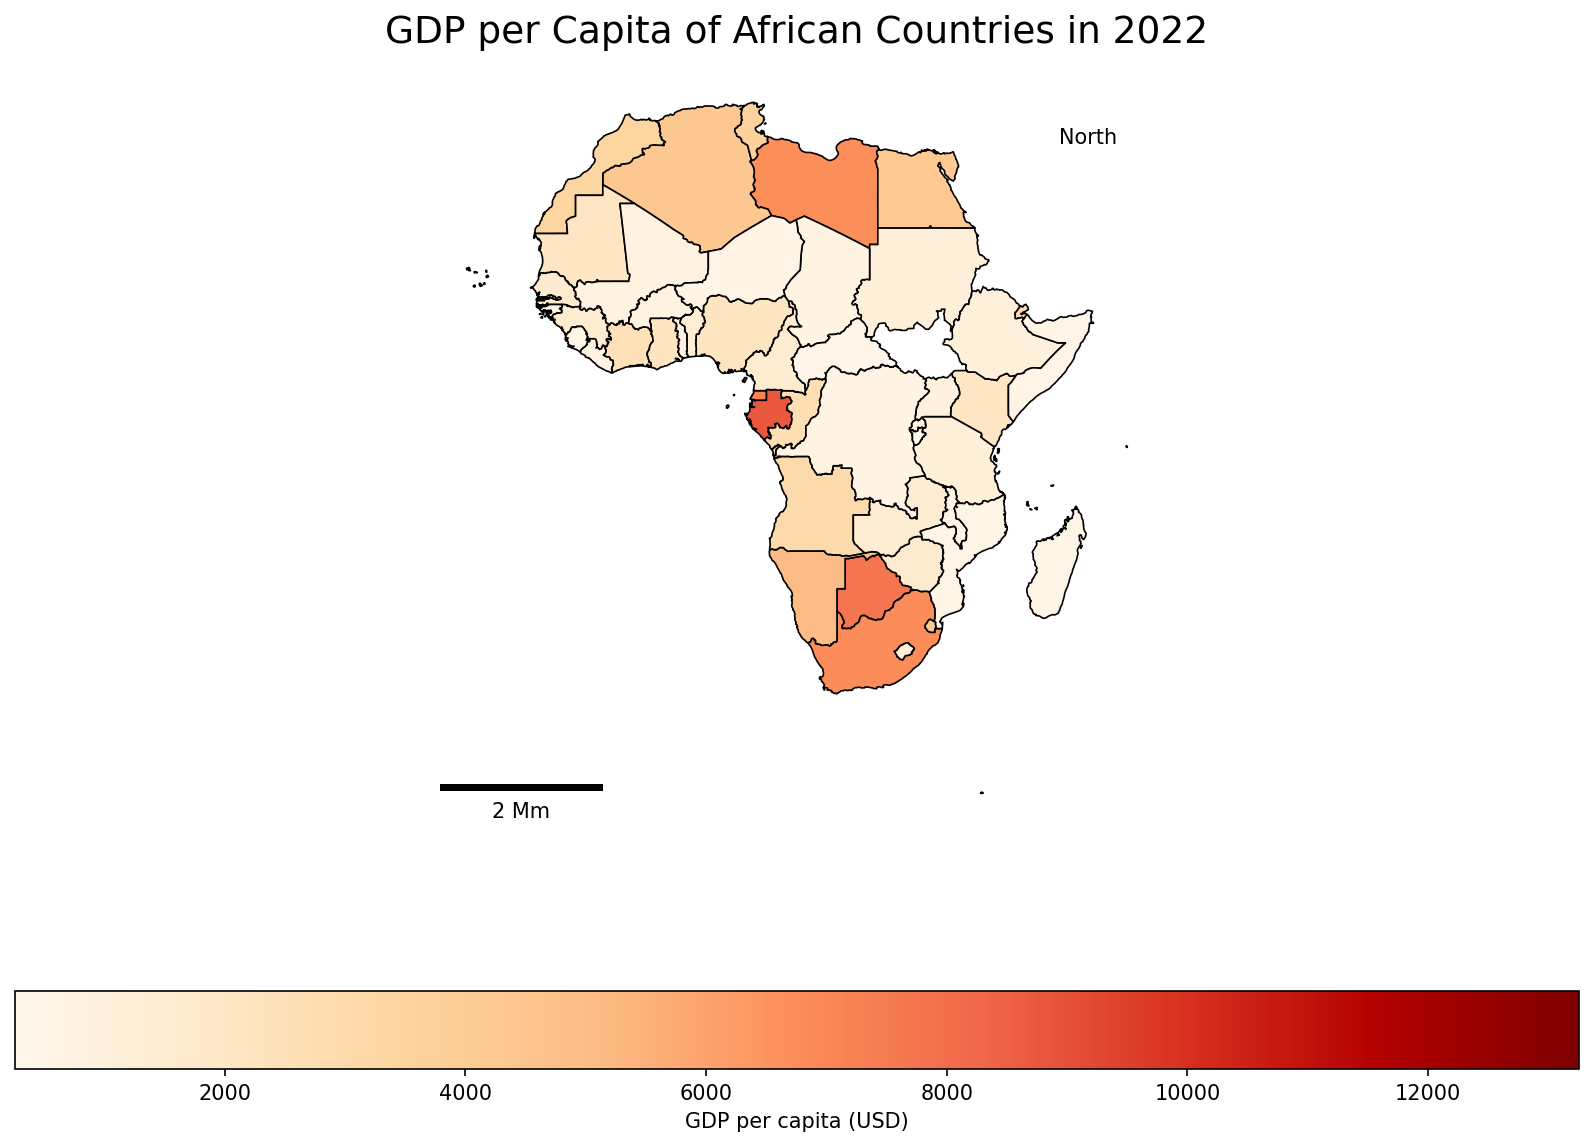

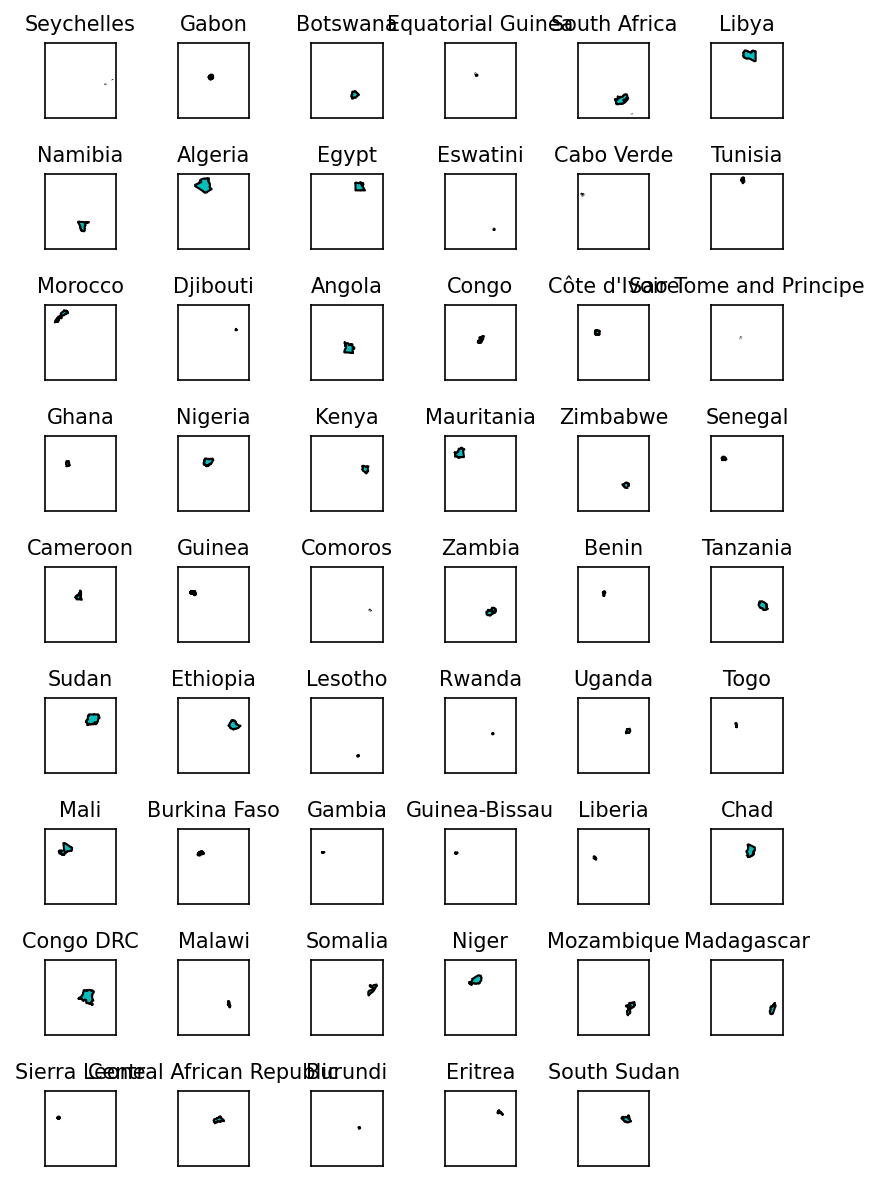

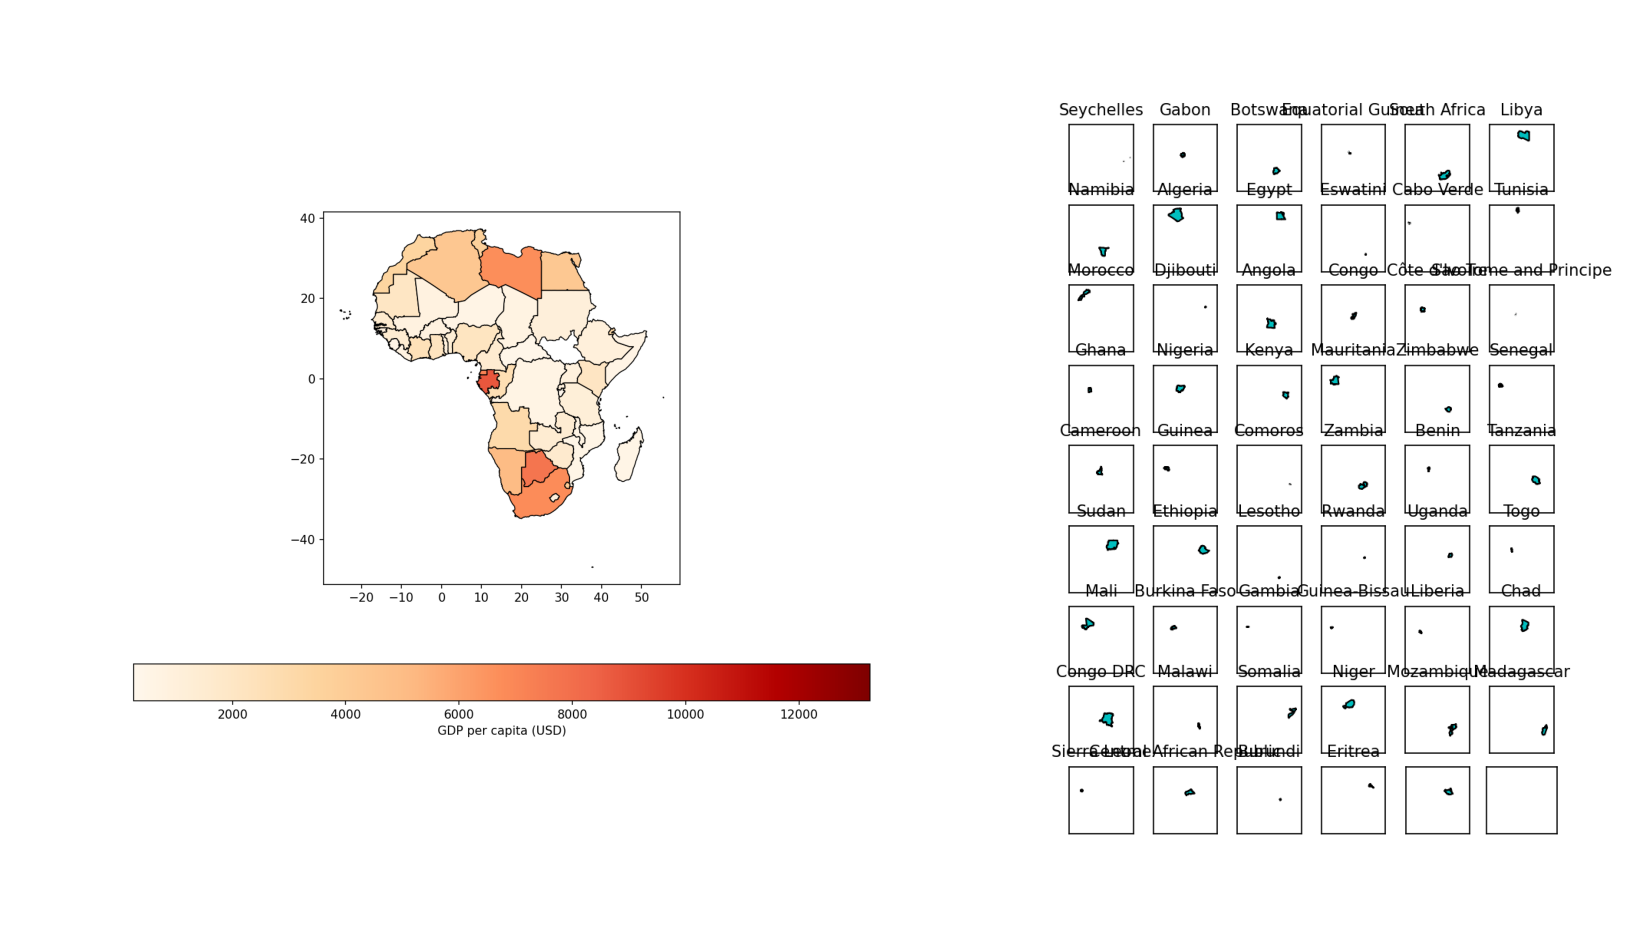

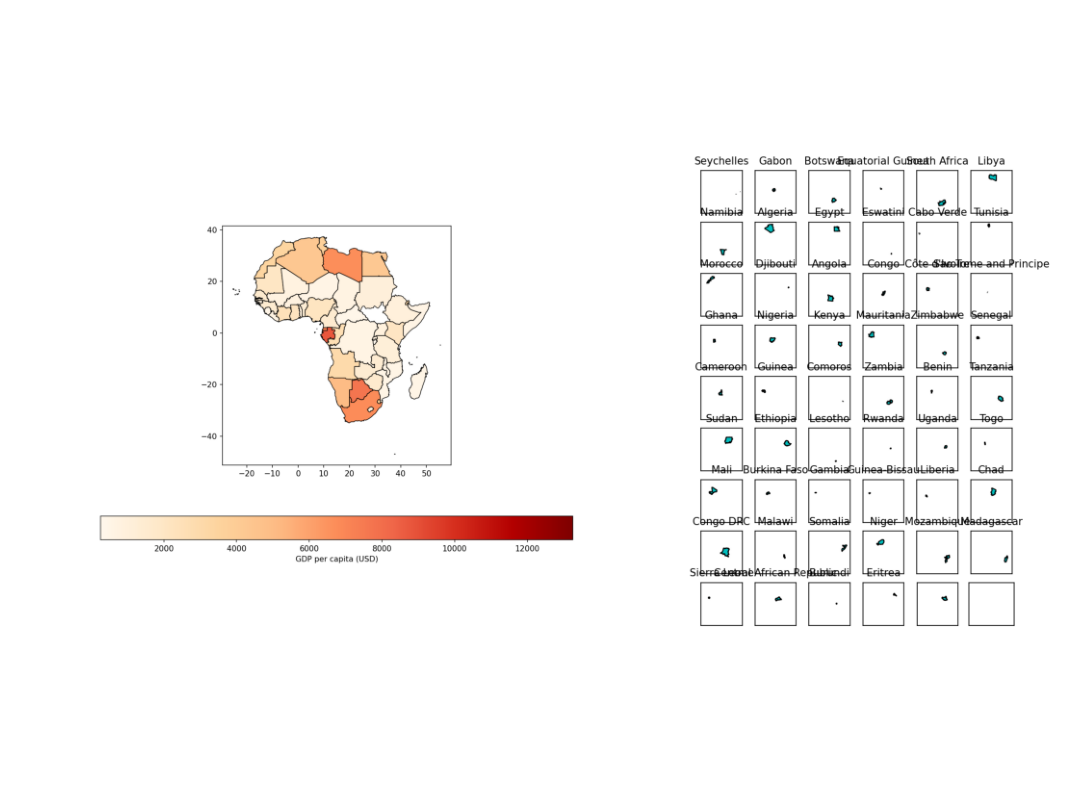

In [95]:
# solution.get_beautify_text_prompt(solution.all_code)

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')
 
 
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

  
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 2

Revising the map, trial 1 / 1
Current map issues:
1. The scaling and positioning of the two parts of the map (continent map and matrix map) are unbalanced; the continent map and the matrix should maintain proportional and visually balanced sizes.
2. The legend and color scheme in the continent map need to be clearer and more closely integrated with the map's visual style.
3. The map matrix submaps lack a consistent color mapping with the main continent map, creating a visual disconnect.
4. Text annotations, especially for countries in the matrix submaps, are too small or cluttered, hindering readability.
5. The map lacks a seamless integration of its elements such as the scale bar, legend, and annotations for a clean and professional look.
6. North arrow and map design annotations are not prominently displayed or effectively integrated.

Improvement:
1. Adjust the layout to better integrate the continent map with the matrix map ensuring size and position harmony.
2. Enhance the legend 

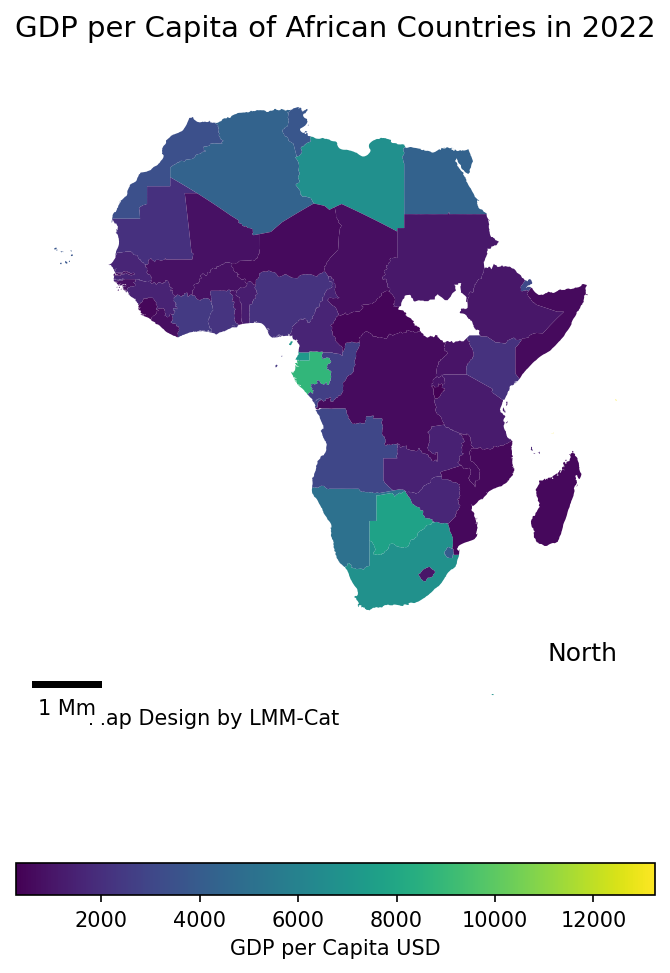

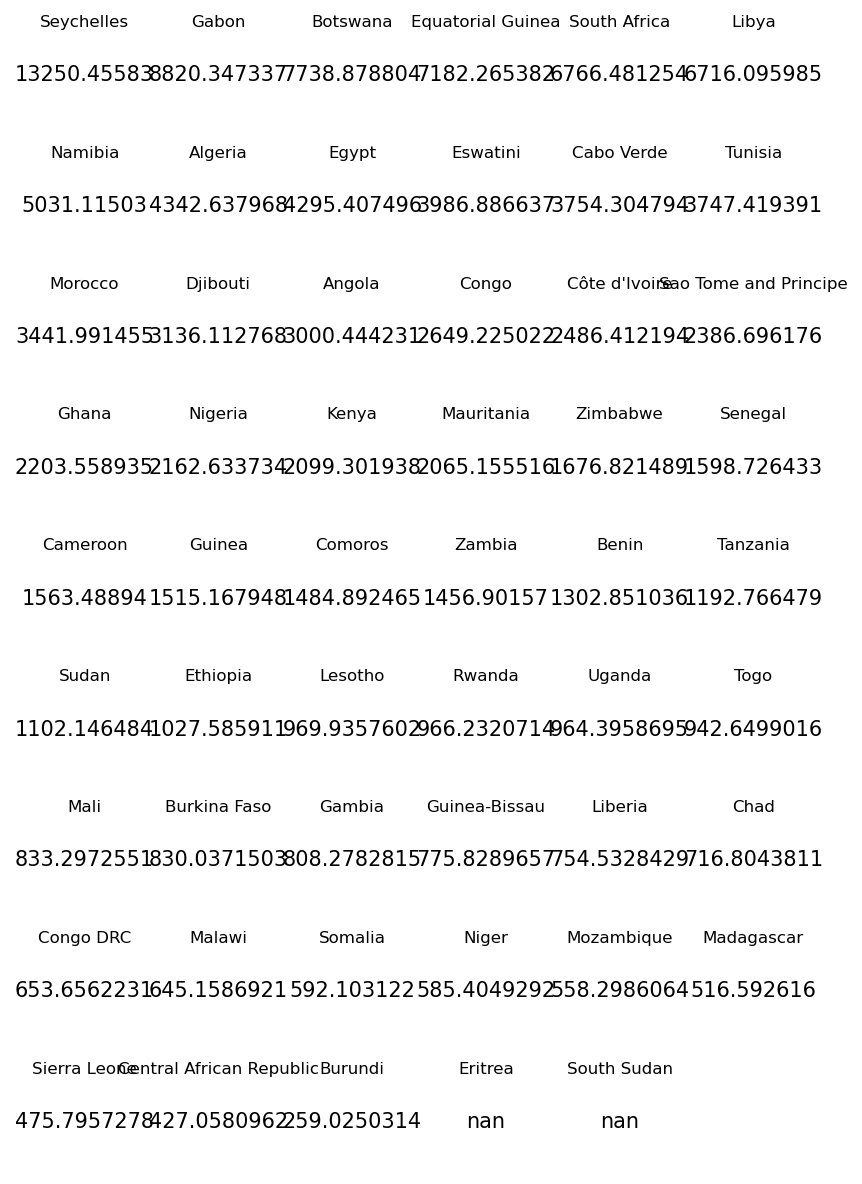

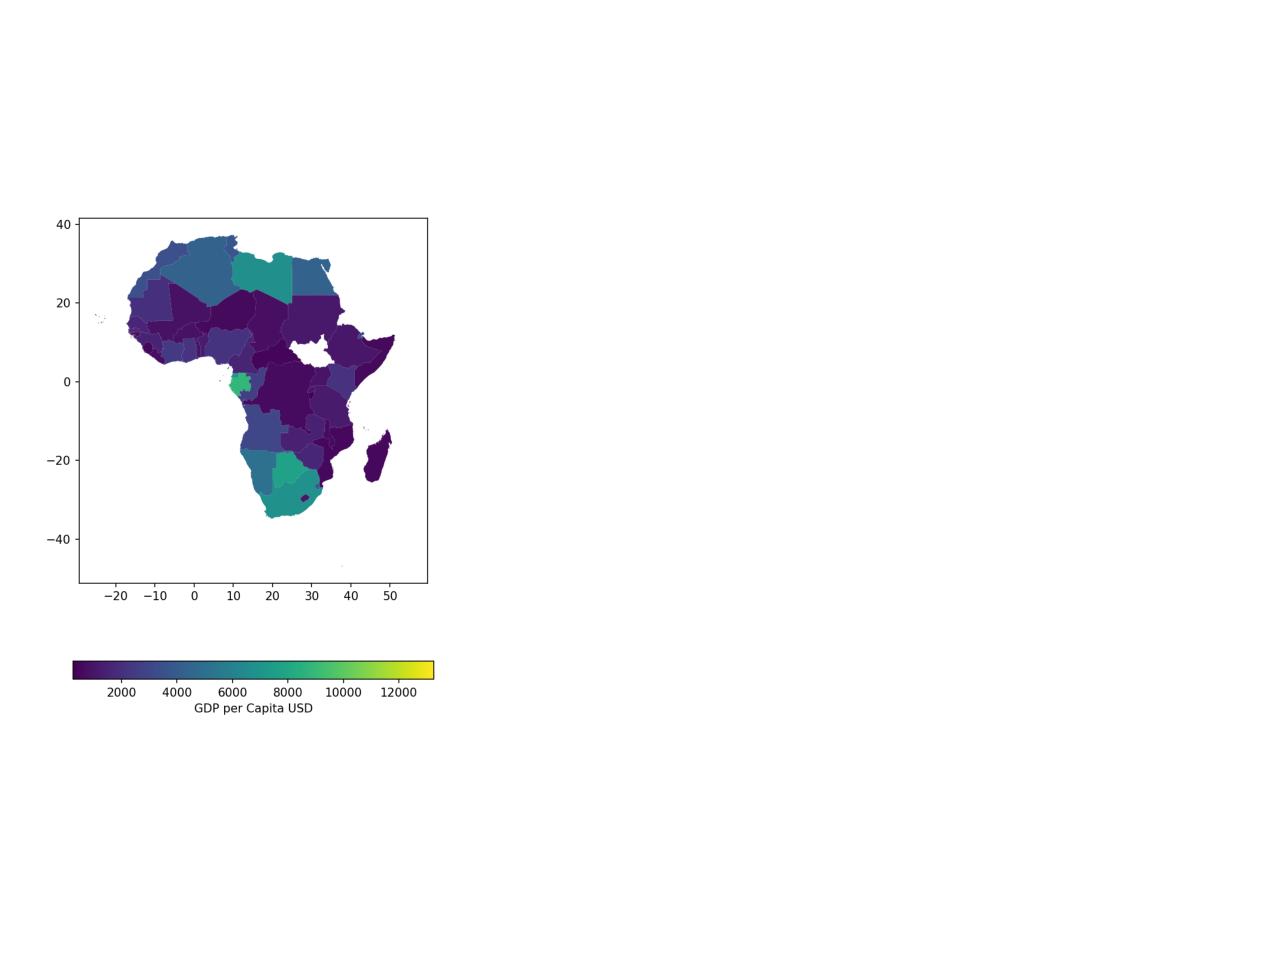



--------------- Done ---------------




import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar

def load_gdp_data():
    gdp_gdf = gpd.read_file("ESRI_countries_4326_GDP.gpkg")
    gdp_gdf = gdp_gdf[['COUNTRY', 'UN_Geodata_simplified_georeg', 'country_per_capita_GDP_2022', 'geometry']].copy()
    gdp_gdf['country_per_capita_GDP_2022'] = pd.to_numeric(gdp_gdf['country_per_capita_GDP_2022'], errors='coerce')
    return gdp_gdf

def filter_african_countries(gdp_gdf):
    african_gdf = gdp_gdf[gdp_gdf['UN_Geodata_simplified_georeg'] == 'AFR'].copy()
    return african_gdf

def sort_by_gdp(african_gdf):
    return african_gdf.sort_values(by='country_per_capita_GDP_2022', ascending=False)

def create_choropleth_main(sorted_african_gdf):
    fig, ax = plt.subplots(figsize=(5.5, 8), dpi=150)
    sorted_african_gdf.plot(column='country_per_capita_GDP_2022', ax=ax, legend=True, cmap='viridis',
                            legend_kwds={'label': "GDP per Capita USD", 'orientation': "horizontal"})
    ax.set_title('GDP per Capita of African Countries in 2022', fontsize=14, pad=20)
    ax.set_axis_off()
    scalebar = ScaleBar(100, units='km', location='lower left')
    ax.add_artist(scalebar)
    north = ax.annotate('North', xy=(0.9, 0.1), xycoords='axes fraction', fontsize=12, ha='center')
    ax.annotate('Map Design by LMM-Cat', xy=(0.1, 0), xycoords='axes fraction', fontsize=10)
    return fig

def create_submaps(sorted_african_gdf):
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(5.5, 8), dpi=150)
    for i, ax in enumerate(axes.flatten()):
        if i < len(sorted_african_gdf):
            data = sorted_african_gdf.iloc[i]
            ax.set_title(data['COUNTRY'], fontsize=8)
            ax.annotate(data['country_per_capita_GDP_2022'], xy=(0.5, 0.5), xycoords='axes fraction', ha='center')
            ax.set_axis_off()
        else:
            ax.set_visible(False)
    plt.tight_layout()
    return fig

def combine_maps(main_map, submaps):
    fig = plt.figure(figsize=(11, 8), dpi=150)
    grid = plt.GridSpec(1, 2, width_ratios=[2, 3], figure=fig)
    main_ax = fig.add_subplot(grid[0])
    sub_ax = fig.add_subplot(grid[1])

    main_ax.imshow(main_map.canvas.buffer_rgba())
    sub_ax.imshow(submaps.canvas.buffer_rgba())

    main_ax.axis('off')
    sub_ax.axis('off')

    plt.savefig("output_map.png", dpi=100)
    return fig

def main():
    gdp_gdf = load_gdp_data()
    african_gdf = filter_african_countries(gdp_gdf)
    sorted_african_gdf = sort_by_gdp(african_gdf)
    main_map = create_choropleth_main(sorted_african_gdf)
    submaps = create_submaps(sorted_african_gdf)
    final_map = combine_maps(main_map, submaps)
    plt.show()

main()

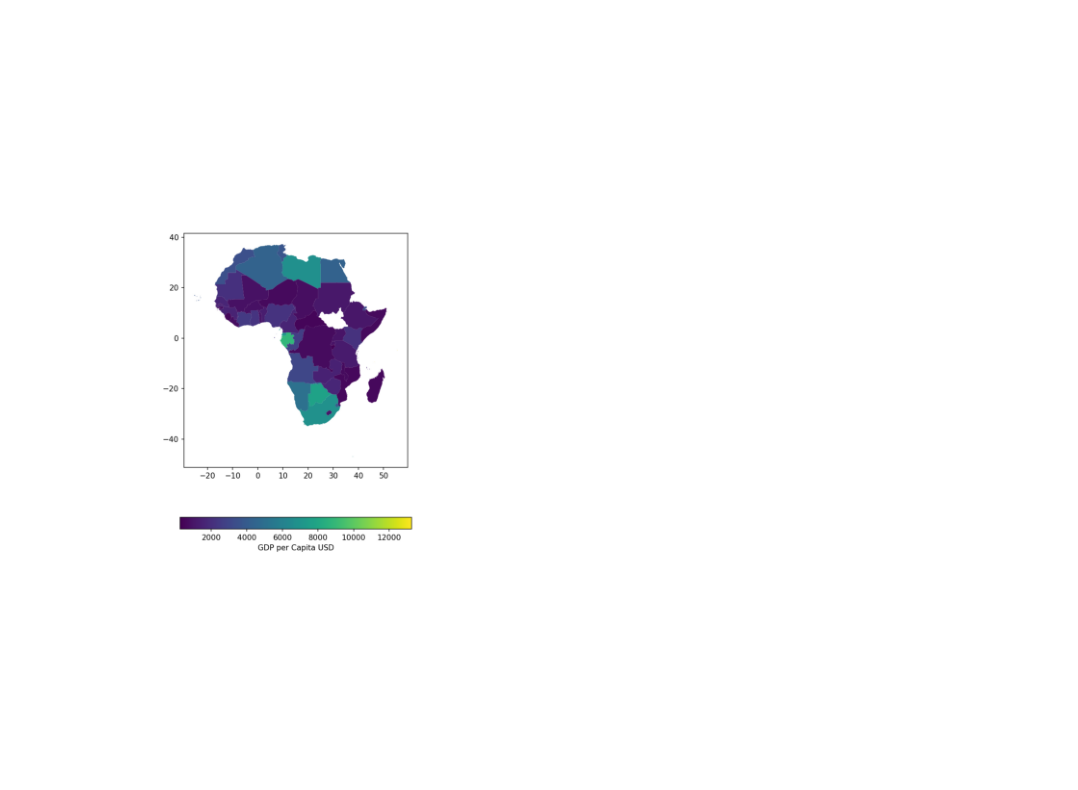

In [96]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()


show_map()
display(Code(all_code, language='python'))



## Beautify 3

Revising the map, trial 1 / 1
Current map issues and improvement approaches:

1. **Title Appearance**: The main map's title font size is too small, making it less noticeable.
2. **Legend Placement and Style**: The legend is horizontally laid out, which might not be the best utilization of space considering the left side maps. Enhancing the readability and position could be improved.
3. **Color Scheme Harmonization**: The map uses a `viridis` colormap, which although functional, could be optimized for visual appeal and better differentiation of GDP ranges.
4. **Scale Bar and Annotation Styling**: The scale bar and annotations can be better integrated aesthetically.
5. **Overall Aesthetic and Balance**: The main map and matrix map need integration in a single view to make visual comparison easier.

Enhanced Python Code Implementation:

```python
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.

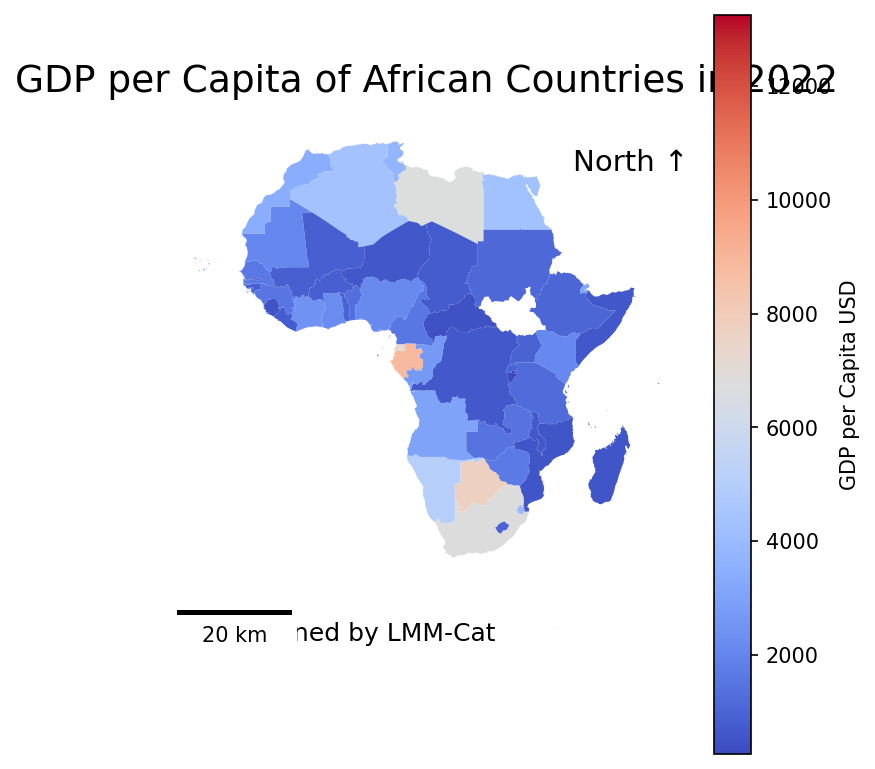

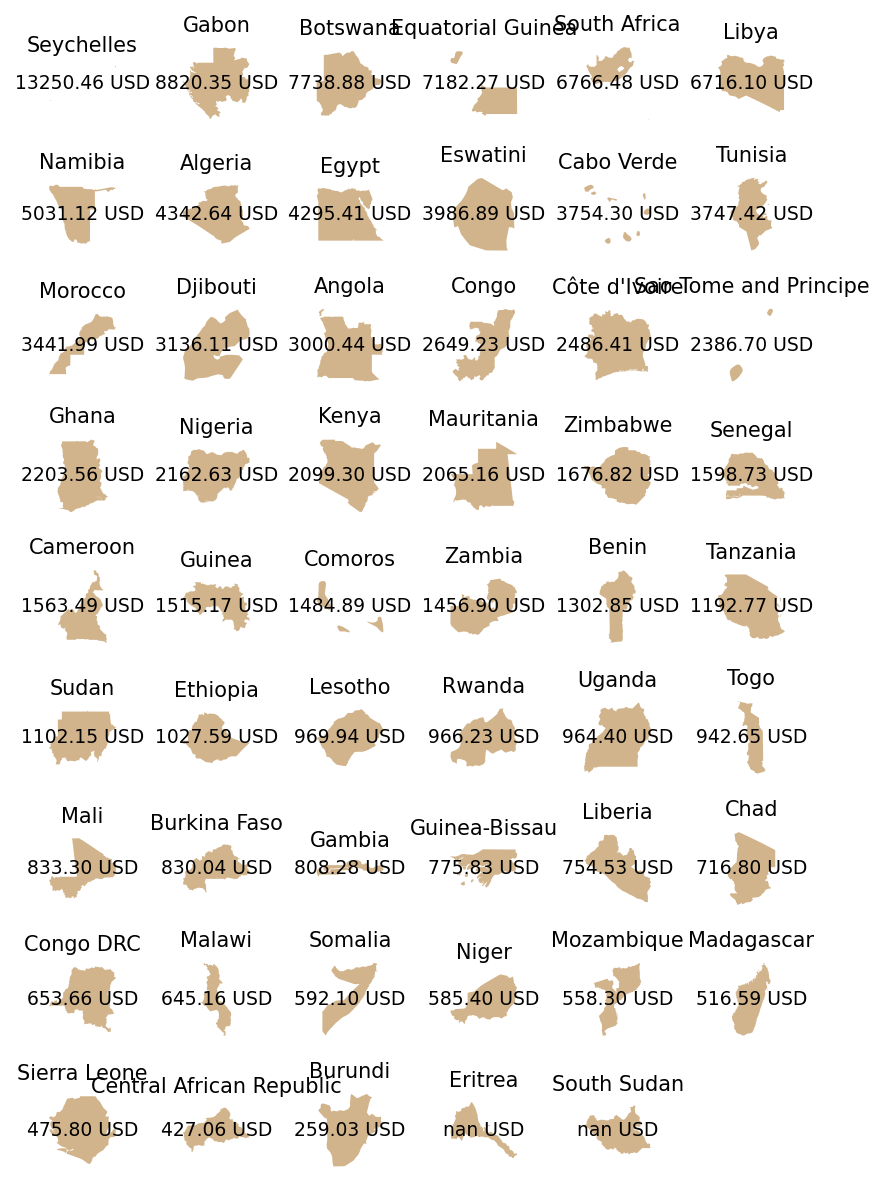

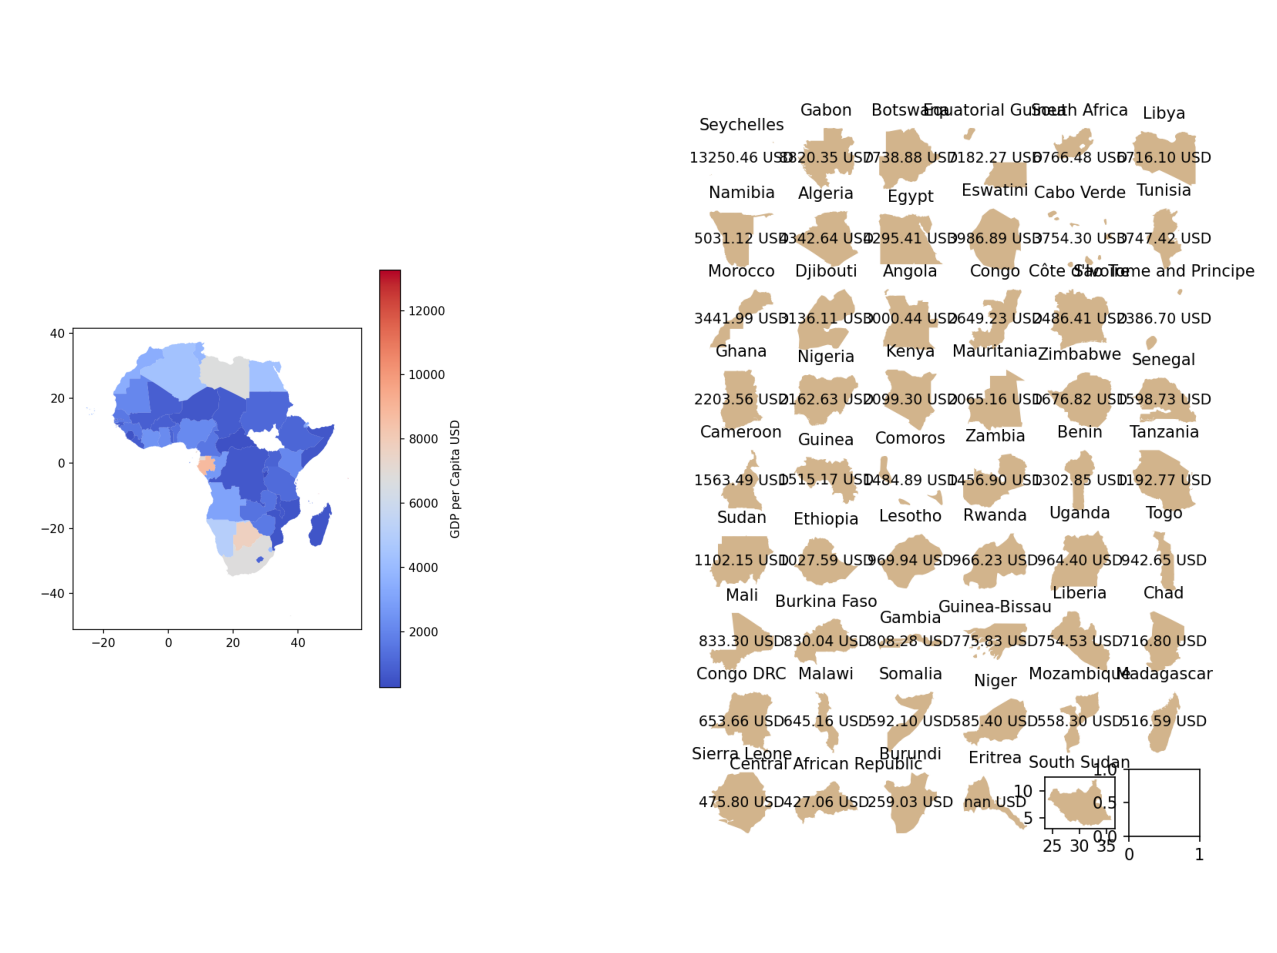



--------------- Done ---------------




import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def load_gdp_data():
    gdp_gdf = gpd.read_file("ESRI_countries_4326_GDP.gpkg")
    gdp_gdf = gdp_gdf[['COUNTRY', 'UN_Geodata_simplified_georeg', 'country_per_capita_GDP_2022', 'geometry']].copy()
    gdp_gdf['country_per_capita_GDP_2022'] = pd.to_numeric(gdp_gdf['country_per_capita_GDP_2022'], errors='coerce')
    return gdp_gdf

def filter_african_countries(gdp_gdf):
    african_gdf = gdp_gdf[gdp_gdf['UN_Geodata_simplified_georeg'] == 'AFR'].copy()
    return african_gdf

def sort_by_gdp(african_gdf):
    return african_gdf.sort_values(by='country_per_capita_GDP_2022', ascending=False)

def create_choropleth_main(sorted_african_gdf):
    fig, ax = plt.subplots(figsize=(5.5, 8), dpi=150)
    sorted_african_gdf.plot(column='country_per_capita_GDP_2022', ax=ax, legend=True, cmap='coolwarm',
                            legend_kwds={'label': "GDP per Capita USD", 'orientation': "vertical", 'shrink': 0.8})
    ax.set_title('GDP per Capita of African Countries in 2022', fontsize=18, pad=12)
    ax.set_axis_off()
    scalebar = ScaleBar(1, units='km', location='lower left', scale_loc='bottom', length_fraction=0.25)
    ax.add_artist(scalebar)
    ax.annotate('North ↑', xy=(0.9, 0.9), xycoords='axes fraction', fontsize=14, ha='center')
    ax.annotate('Designed by LMM-Cat', xy=(0.1, 0.02), xycoords='axes fraction', fontsize=12)
    return fig

def create_submaps(sorted_african_gdf):
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(5.5, 8), dpi=150)
    for i, ax in enumerate(axes.flatten()):
        if i < len(sorted_african_gdf):
            data = sorted_african_gdf.iloc[i]
            ax.set_title(data['COUNTRY'], fontsize=10)
            gpd.GeoSeries([data['geometry']]).plot(ax=ax, color='tan')
            ax.annotate(f"{data['country_per_capita_GDP_2022']:.2f} USD", xy=(0.5, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=9)
            ax.set_axis_off()
        else:
            ax.set_visible(False)
    plt.tight_layout()
    return fig

def combine_maps(main_map, submaps):
    fig = plt.figure(figsize=(11, 8), dpi=150)
    grid = plt.GridSpec(1, 2, width_ratios=[2, 3], figure=fig)
    main_ax = fig.add_subplot(grid[0])
    sub_ax = fig.add_subplot(grid[1])

    main_ax.imshow(main_map.canvas.buffer_rgba())
    sub_ax.imshow(submaps.canvas.buffer_rgba())

    main_ax.axis('off')
    sub_ax.axis('off')

    plt.savefig("output_map.png", dpi=100)
    return fig

def main():
    gdp_gdf = load_gdp_data()
    african_gdf = filter_african_countries(gdp_gdf)
    sorted_african_gdf = sort_by_gdp(african_gdf)
    main_map = create_choropleth_main(sorted_african_gdf)
    submaps = create_submaps(sorted_african_gdf)
    final_map = combine_maps(main_map, submaps)
    plt.show()

main()

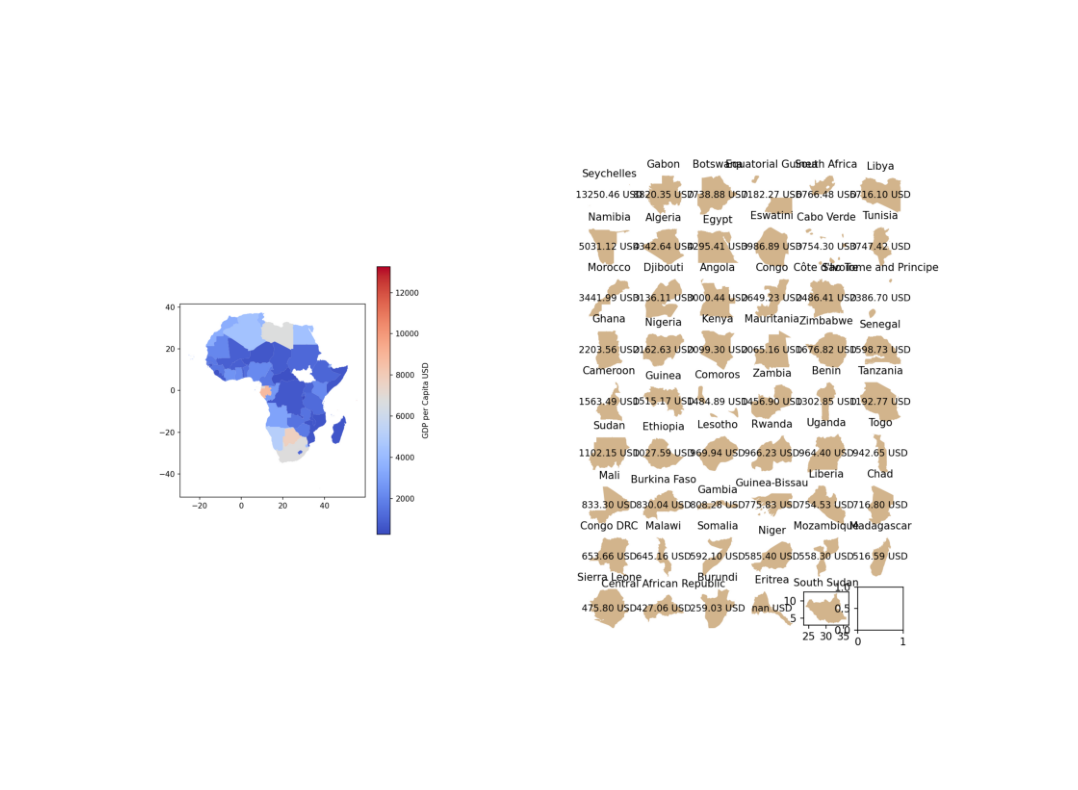

In [97]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 4

Revising the map, trial 1 / 1
Current map issues:
1. The overall layout is cluttered with too much textual information on the right part of the map, making it difficult to quickly grasp and compare data visually.
2. The color scheme on both maps should be more consistent. The main map uses a blue to red gradient, while the submaps use a tan color. This inconsistency might confuse the interpretation.
3. The title "GDP per Capita of African Countries in 2022" on the continent map is good, but it is missing from the overall figure composition which affects the context for the viewer.
4. The scale bar and north arrow on the continent map are too small and not very prominent, which might make them easy to overlook.
5. The font sizes and styles could be more varied to emphasize different elements like country names or GDP values more clearly.

Improvement:
1. Use a consistent color scheme across both maps.
2. Introduce a global title for the entire figure to provide context.
3. Increase the 

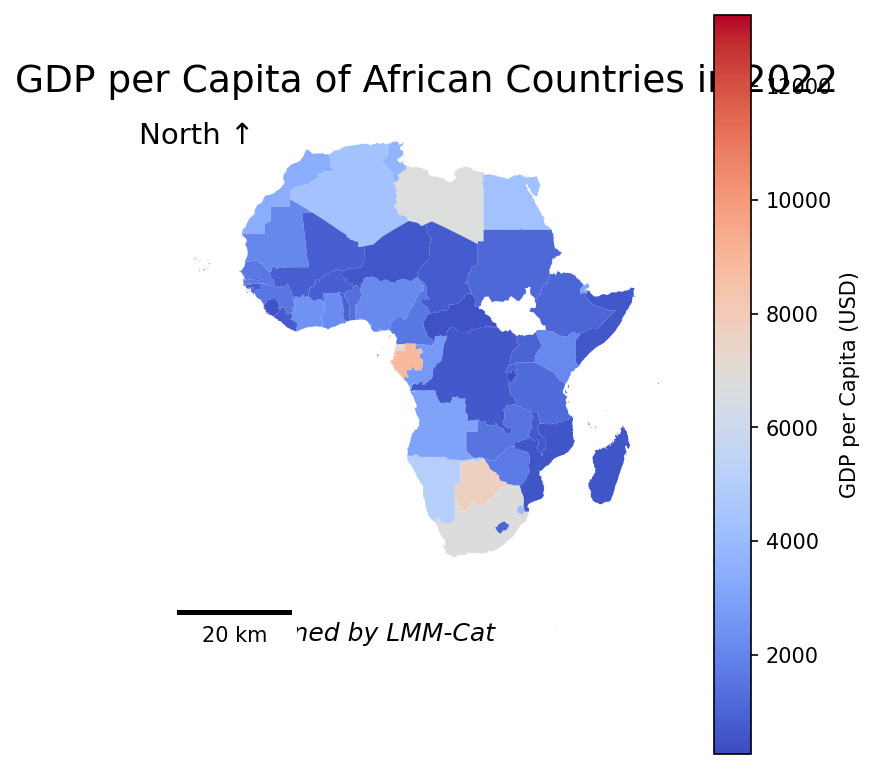

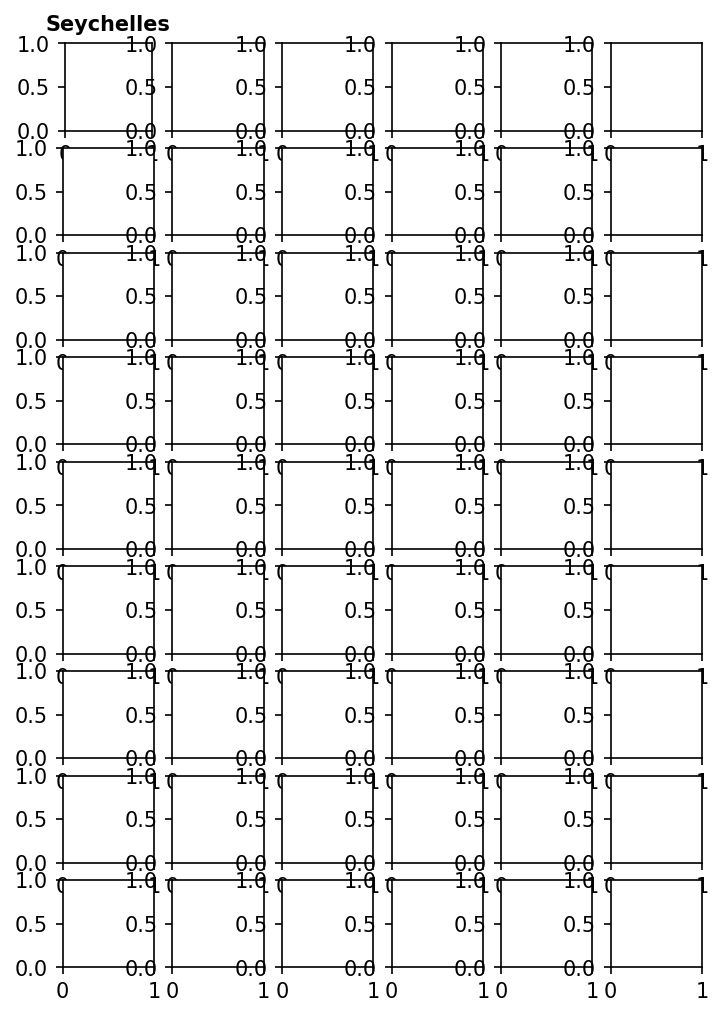

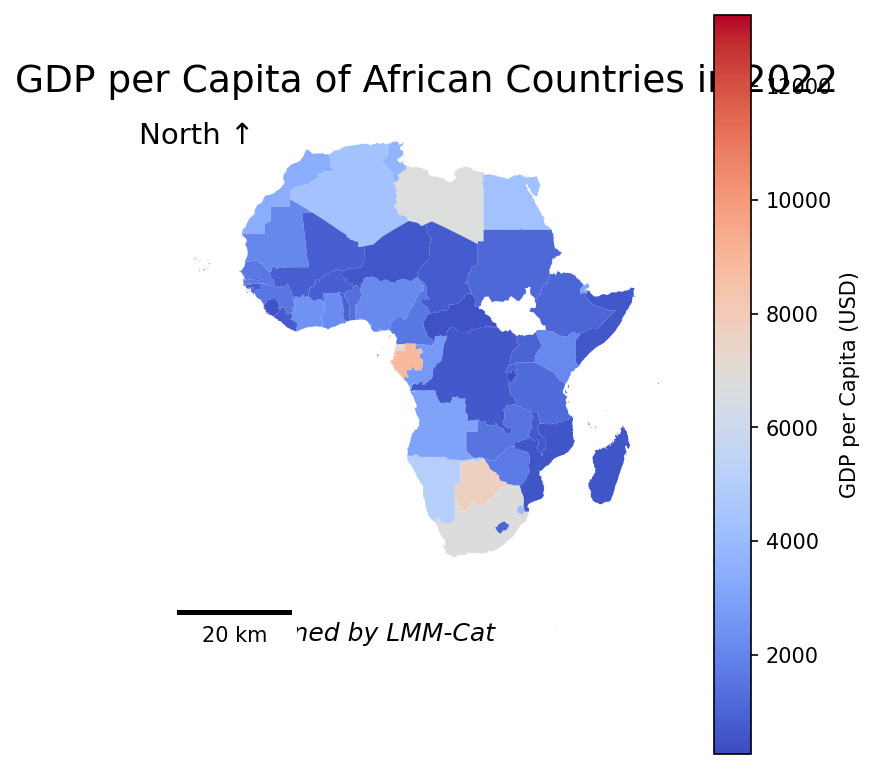

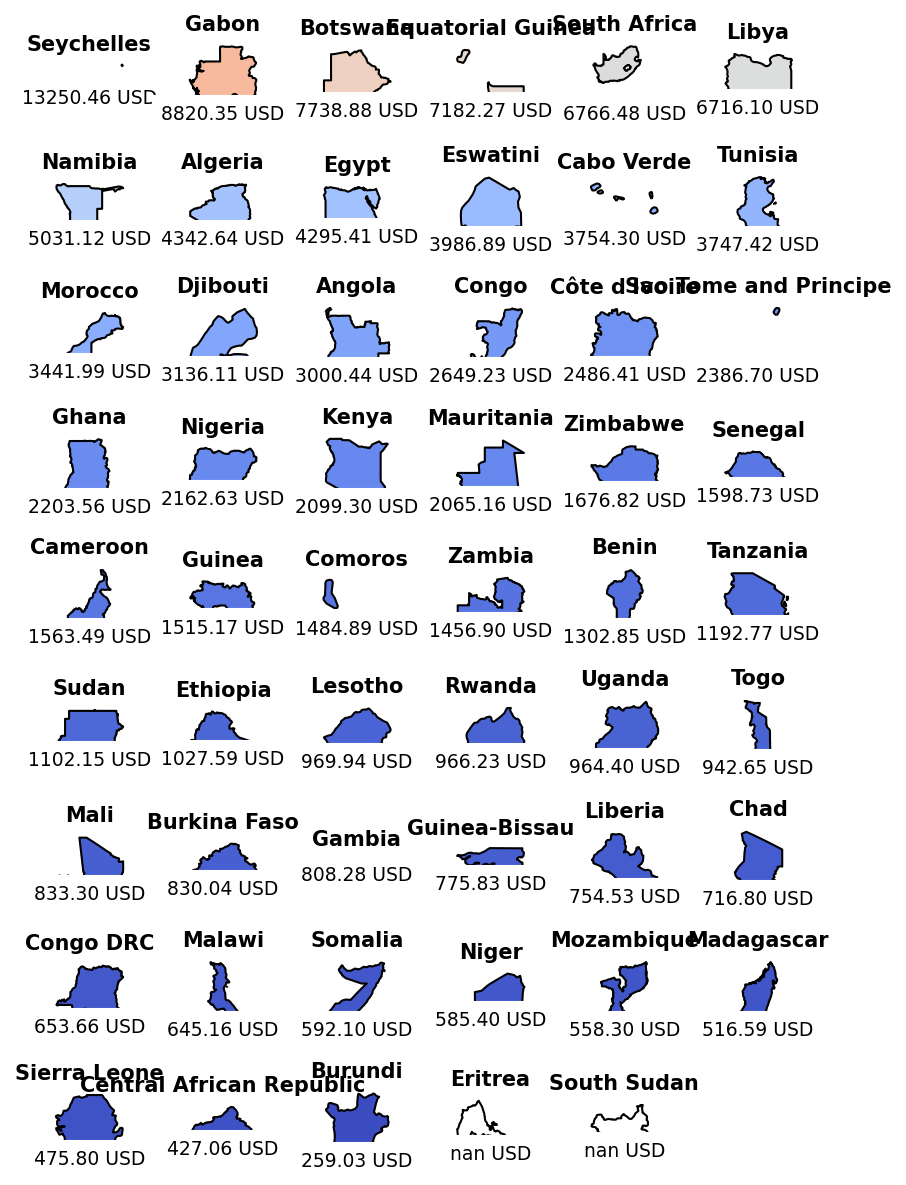

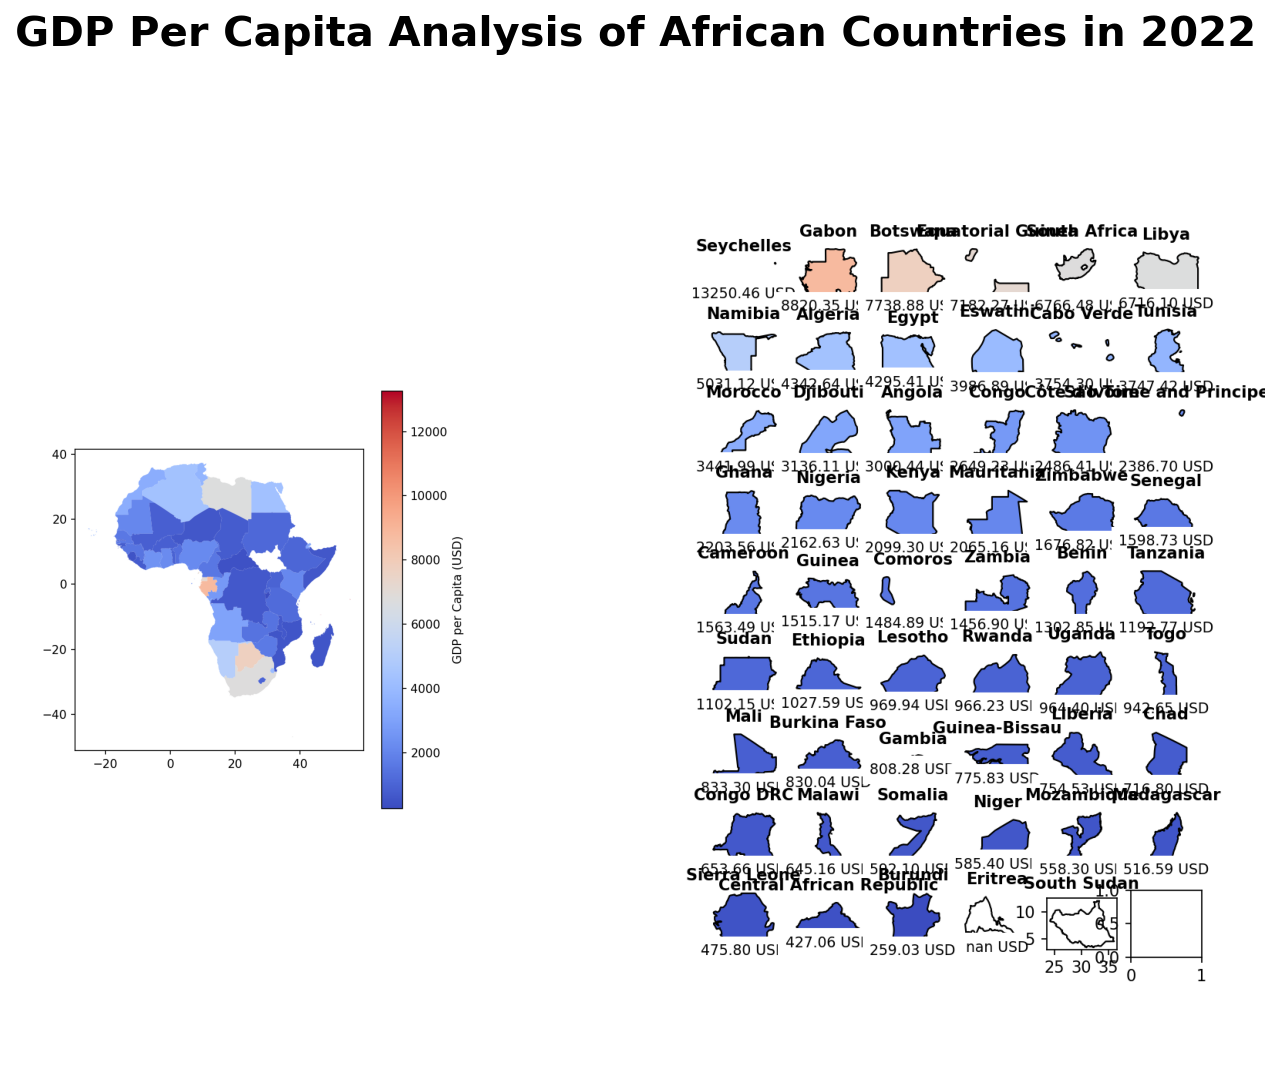



--------------- Done ---------------




import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.colors import Normalize

def load_gdp_data():
    gdp_gdf = gpd.read_file("ESRI_countries_4326_GDP.gpkg")
    gdp_gdf = gdp_gdf[['COUNTRY', 'UN_Geodata_simplified_georeg', 'country_per_capita_GDP_2022', 'geometry']].copy()
    gdp_gdf['country_per_capita_GDP_2022'] = pd.to_numeric(gdp_gdf['country_per_capita_GDP_2022'], errors='coerce')
    return gdp_gdf

def filter_african_countries(gdp_gdf):
    african_gdf = gdp_gdf[gdp_gdf['UN_Geodata_simplified_georeg'] == 'AFR'].copy()
    return african_gdf

def sort_by_gdp(african_gdf):
    return african_gdf.sort_values(by='country_per_capita_GDP_2022', ascending=False)

def create_choropleth_main(sorted_african_gdf):
    fig, ax = plt.subplots(figsize=(5.5, 8), dpi=150)
    # Generate the colormap
    norm = Normalize(vmin=sorted_african_gdf['country_per_capita_GDP_2022'].min(), vmax=sorted_african_gdf['country_per_capita_GDP_2022'].max())
    cbar = plt.cm.ScalarMappable(norm=norm, cmap="coolwarm")
    
    sorted_african_gdf.plot(column='country_per_capita_GDP_2022', ax=ax, legend=True, cmap='coolwarm',
                            legend_kwds={'label': "GDP per Capita (USD)", 'orientation': "vertical", 'shrink': 0.8})
    ax.set_title('GDP per Capita of African Countries in 2022', fontsize=18, pad=12)
    ax.set_axis_off()
    scalebar = ScaleBar(1, units='km', location='lower left', scale_loc='bottom', length_fraction=0.25, frameon=True)
    ax.add_artist(scalebar)
    ax.annotate('North ↑', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14, ha='center')
    ax.annotate('Designed by LMM-Cat', xy=(0.1, 0.02), xycoords='axes fraction', fontsize=12, style='italic')
    return fig, cbar

def create_submaps(sorted_african_gdf, colorbar):
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(5.5, 8), dpi=150)
    for i, ax in enumerate(axes.flatten()):
        if i < len(sorted_african_gdf):
            data = sorted_african_gdf.iloc[i]
            ax.set_title(data['COUNTRY'], fontsize=10, fontweight='bold')
            # Extract color for the specific GDP value
            color = colorbar.to_rgba(data['country_per_capita_GDP_2022'])
            gpd.GeoSeries([data['geometry']]).plot(ax=ax, color=color, edgecolor='black')
            ax.annotate(f"{data['country_per_capita_GDP_2022']:.2f} USD", xy=(0.5, 0.1), xycoords='axes fraction', ha='center', va='center', fontsize=9, color='black', backgroundcolor='white')
            ax.set_axis_off()
        else:
            ax.set_visible(False)
    plt.tight_layout()
    return fig

def combine_maps(main_map, submaps):
    fig = plt.figure(figsize=(11, 8), dpi=150)
    grid = plt.GridSpec(1, 2, width_ratios=[2, 3], figure=fig)
    main_ax = fig.add_subplot(grid[0])
    sub_ax = fig.add_subplot(grid[1])

    main_ax.imshow(main_map.canvas.buffer_rgba())
    sub_ax.imshow(submaps.canvas.buffer_rgba())

    main_ax.axis('off')
    sub_ax.axis('off')

    plt.suptitle('GDP Per Capita Analysis of African Countries in 2022', fontsize=20, fontweight='bold')
    plt.savefig("output_map.png", dpi=100)
    return fig

def main():
    gdp_gdf = load_gdp_data()
    african_gdf = filter_african_countries(gdp_gdf)
    sorted_african_gdf = sort_by_gdp(african_gdf)
    main_map, colorbar = create_choropleth_main(sorted_african_gdf)
    submaps = create_submaps(sorted_african_gdf, colorbar)
    final_map = combine_maps(main_map, submaps)
    plt.show()

main()

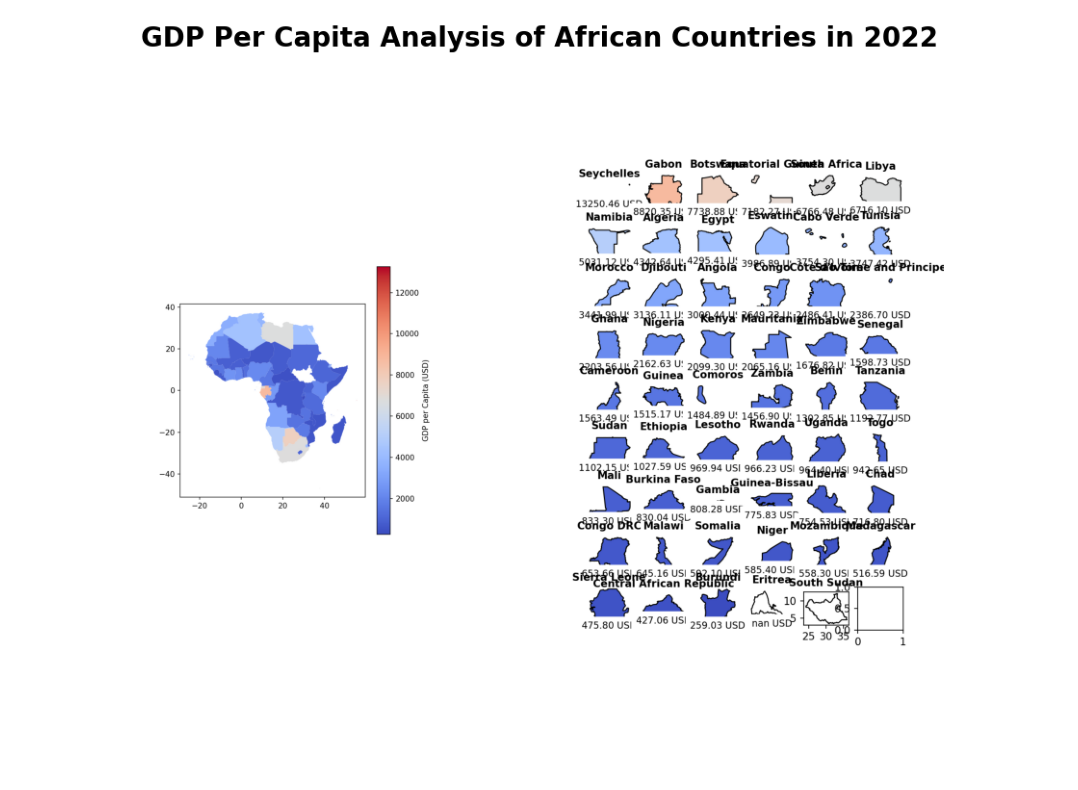

In [98]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

## Beautify 5

Revising the map, trial 1 / 1
Current map issues:
1. **Title Clarity and Visibility**: The main map title is decently sized, but there is no clear title for the matrix of individual countries, making it slightly confusing for viewers.
2. **Legibility of Annotations**: In the small maps, the annotations displaying GDP are sometimes clashing with the country borders, reducing readability.
3. **Inconsistency in Visualization**: The scale bar and color bar are only present on the larger map, not helping much when looking at the smaller maps. There's no indication of scale or north in the small maps.
4. **Unbalanced Layout**: The two parts of the map (the large map and the matrix of smaller maps) have a slightly unbalanced size distribution which might be visually uncomfortable. This unbalance may draw viewers' attention unevenly between the two map displays.
5. **Overlapping Labels**: Some labels in the small map matrix seem to overlap slightly with adjacent maps.

Improvement:
1. Introduc

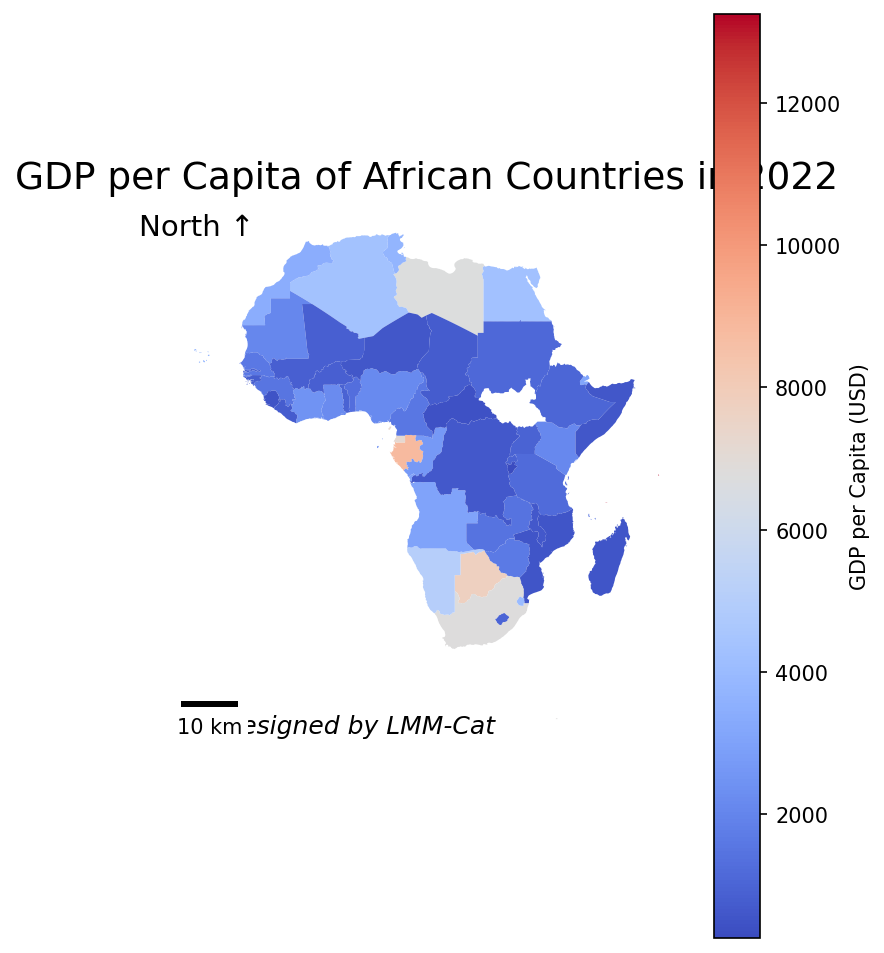

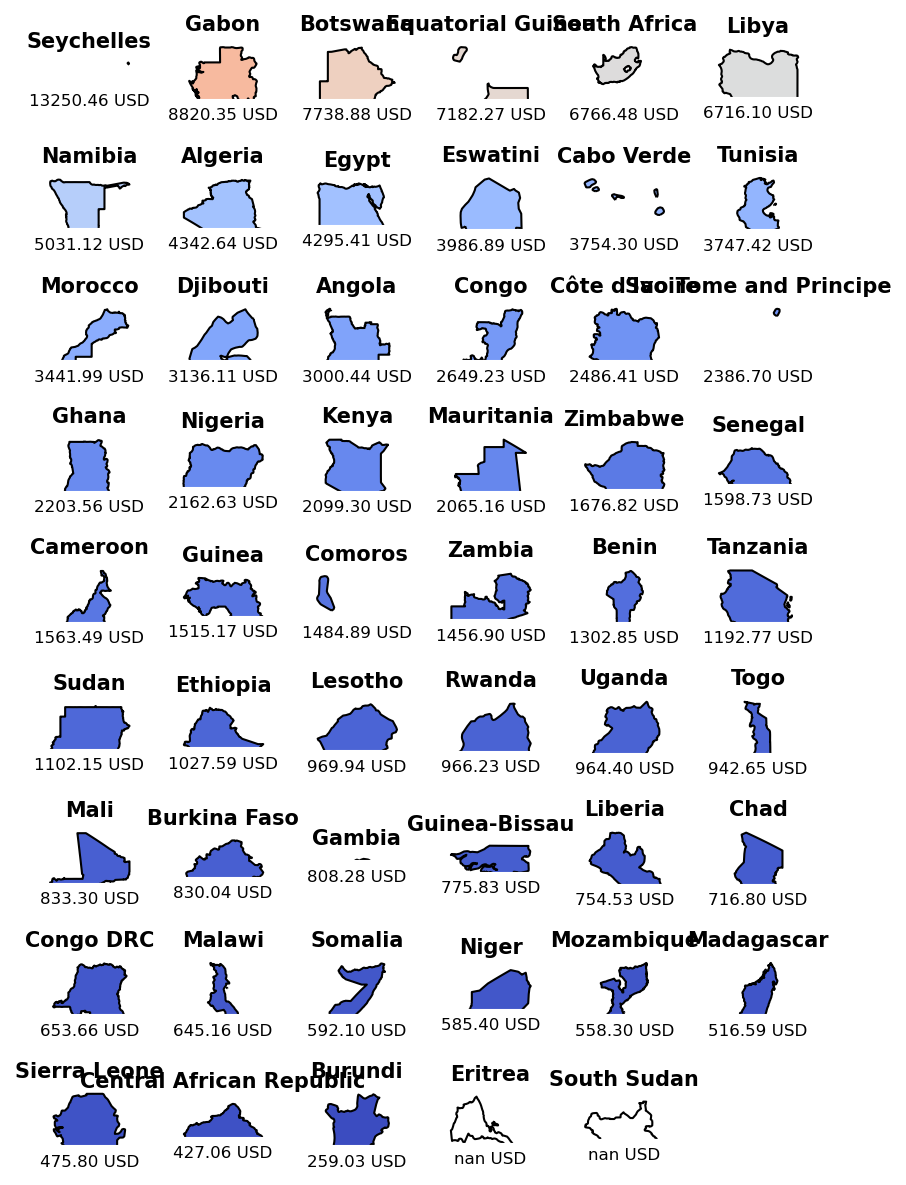

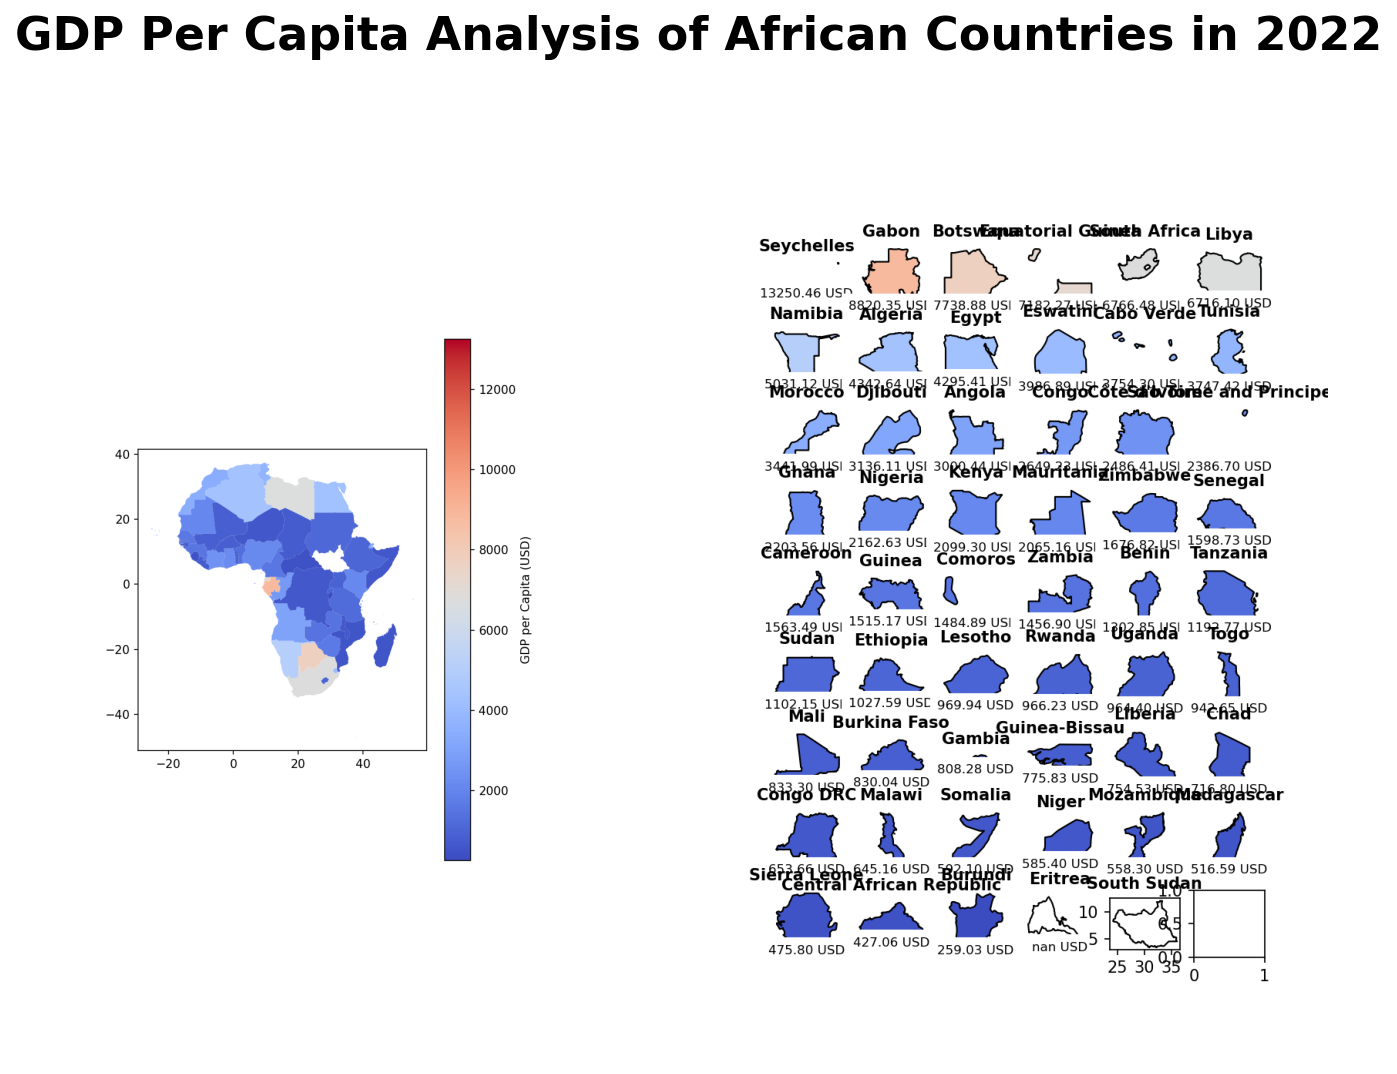



--------------- Done ---------------




import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.colors import Normalize
import pandas as pd

def load_gdp_data():
    gdp_gdf = gpd.read_file("ESRI_countries_4326_GDP.gpkg")
    gdp_gdf = gdp_gdf[['COUNTRY', 'UN_Geodata_simplified_georeg', 'country_per_capita_GDP_2022', 'geometry']].copy()
    gdp_gdf['country_per_capita_GDP_2022'] = pd.to_numeric(gdp_gdf['country_per_capita_GDP_2022'], errors='coerce')
    return gdp_gdf

def filter_african_countries(gdp_gdf):
    african_gdf = gdp_gdf[gdp_gdf['UN_Geodata_simplified_georeg'] == 'AFR'].copy()
    return african_gdf

def sort_by_gdp(african_gdf):
    return african_gdf.sort_values(by='country_per_capita_GDP_2022', ascending=False)

def create_choropleth_main(sorted_african_gdf):
    fig, ax = plt.subplots(figsize=(5.5, 8), dpi=150)
    norm = Normalize(vmin=sorted_african_gdf['country_per_capita_GDP_2022'].min(), vmax=sorted_african_gdf['country_per_capita_GDP_2022'].max())
    cbar = plt.cm.ScalarMappable(norm=norm, cmap="coolwarm")
    
    sorted_african_gdf.plot(column='country_per_capita_GDP_2022', ax=ax, legend=True, cmap='coolwarm',
                            legend_kwds={'label': "GDP per Capita (USD)", 'orientation': "vertical"})
    ax.set_title('GDP per Capita of African Countries in 2022', fontsize=18, pad=10)
    ax.set_axis_off()
    scalebar = ScaleBar(1, units='km', location='lower left', scale_loc='bottom', length_fraction=0.15, frameon=True)
    ax.add_artist(scalebar)
    ax.annotate('North ↑', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14, ha='center')
    ax.annotate('Designed by LMM-Cat', xy=(0.1, 0.02), xycoords='axes fraction', fontsize=12, style='italic')
    return fig, cbar

def create_submaps(sorted_african_gdf, colorbar):
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(5.5, 8), dpi=150)
    for i, ax in enumerate(axes.flatten()):
        if i < len(sorted_african_gdf):
            data = sorted_african_gdf.iloc[i]
            ax.set_title(data['COUNTRY'], fontsize=10, fontweight='bold')
            color = colorbar.to_rgba(data['country_per_capita_GDP_2022'])
            gpd.GeoSeries([data['geometry']]).plot(ax=ax, color=color, edgecolor='black')
            ax.annotate(f"{data['country_per_capita_GDP_2022']:.2f} USD", xy=(0.5, 0.1), xycoords='axes fraction', ha='center', va='center', fontsize=8, color='black', backgroundcolor='white')
            ax.set_axis_off()
        else:
            ax.set_visible(False)
    plt.tight_layout()
    return fig

def combine_maps(main_map, submaps):
    fig = plt.figure(figsize=(11, 8), dpi=150)
    grid = plt.GridSpec(1, 2, width_ratios=[2, 3], figure=fig)
    main_ax = fig.add_subplot(grid[0])
    sub_ax = fig.add_subplot(grid[1])

    main_ax.imshow(main_map.canvas.buffer_rgba())
    sub_ax.imshow(submaps.canvas.buffer_rgba())

    main_ax.axis('off')
    sub_ax.axis('off')

    plt.suptitle('GDP Per Capita Analysis of African Countries in 2022', fontsize=22, fontweight='bold')
    plt.savefig("output_map.png", dpi=100)
    return fig

def main():
    gdp_gdf = load_gdp_data()
    african_gdf = filter_african_countries(gdp_gdf)
    sorted_african_gdf = sort_by_gdp(african_gdf)
    main_map, colorbar = create_choropleth_main(sorted_african_gdf)
    submaps = create_submaps(sorted_african_gdf, colorbar)
    final_map = combine_maps(main_map, submaps)
    plt.show()

main()

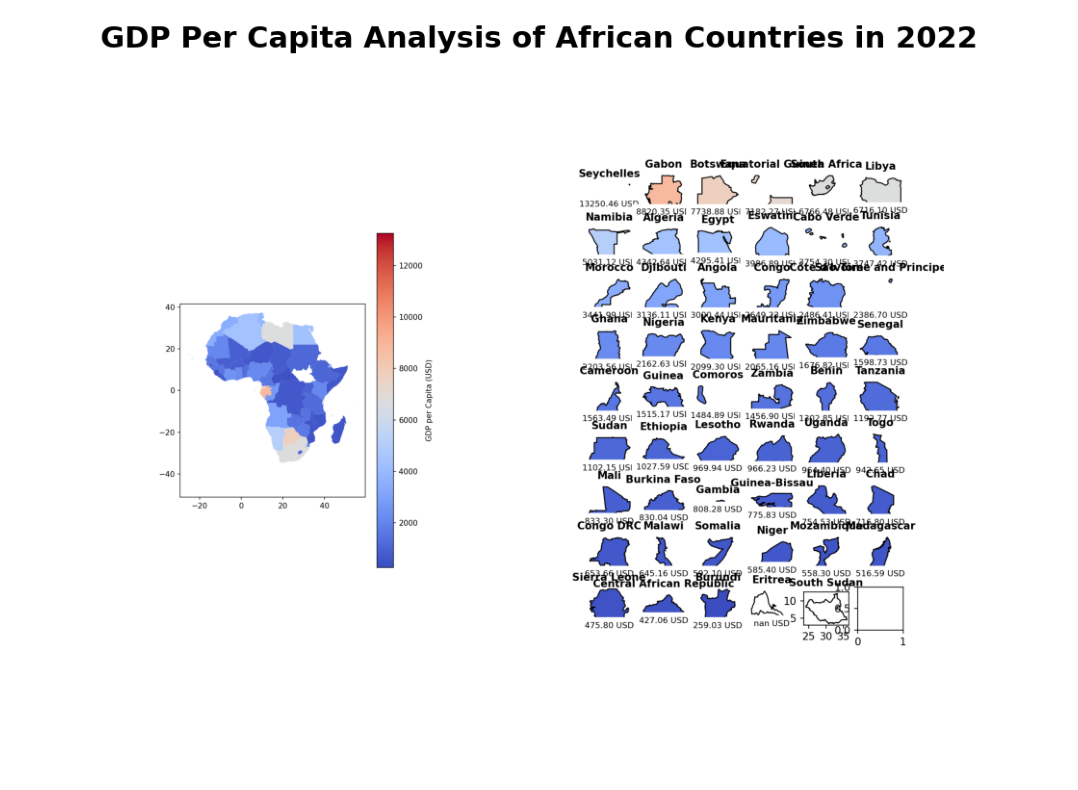

In [99]:
beautify_cnt = 1

for i in range(beautify_cnt):
    
    print(f"Revising the map, trial {i + 1} / {beautify_cnt}")
    
    base64_image = encode_image(image_path)

    solution.ask_LLM_to_beautify_map(map_base64=base64_image, model='gpt-4-turbo')

    all_code = solution.execute_complete_program(code=solution.all_code, try_cnt=10)

    solution.all_code = all_code
    
    solution.save_solution()

show_map()
display(Code(all_code, language='python'))

In [100]:
STOP

NameError: name 'STOP' is not defined

# Tools


## load a solution

In [ ]:

# import pickle

# saved_fname = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM-Cat\Census_map\Census_map.pkl"
# file = open(saved_fname, 'rb')

# solution = pickle.load(file)

# file.close()
# print(solution.task)